In [1]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
import time
from pathlib import Path

INPUT_FILE = "amenities_quick.csv"

# Dublin city-centre (O’Connell Bridge)
CITY_CENTRE_LAT, CITY_CENTRE_LON = 53.3498, -6.2603

# Dublin-only bounding box (city + county)
DUB_LAT_MIN, DUB_LAT_MAX = 53.15, 53.45
DUB_LON_MIN, DUB_LON_MAX = -6.50, -6.05

In [2]:
df = pd.read_csv(INPUT_FILE)
print(f"Loaded {len(df)} rows, {df.shape[1]} cols")

# drop any *_x columns from prior merges
drop_cols = [c for c in df.columns if c.endswith("_x")]
if drop_cols:
    df = df.drop(columns=drop_cols)

# de-dup on URL just in case
if "URL" in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=["URL"]).reset_index(drop=True)
    print(f"De-duplicated on URL: {before} -> {len(df)}")
else:
    print("⚠️ No URL column found to de-duplicate on")

df.head(3)

Loaded 1228 rows, 37 cols
De-duplicated on URL: 1228 -> 1134


,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km_y,...,nearest_bus_stop_km_y,nearest_rail_station_km_y,nearest_tram_stop_km_y,nearest_park_name_y,nearest_beach_name_y,nearest_gym_name_y,nearest_supermarket_name_y,nearest_bus_stop_name_y,nearest_rail_station_name_y,nearest_tram_stop_name_y
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3.0,3.0,House,C1,4000.0,53.306745,-6.288758,4.014,...,3.602,4.469,3.235,St Stephen's Green,Sandymount Strand,FlyeFit Georges St,Lidl Rathmines,Leeson St Lwr Stop,Heuston Station,Charlemont Luas
1,https://www.daft.ie/for-rent/apartment-the-pin...,"The Pines, Herbert Park Lane, Ballsbridge, Dub...",2.0,2.0,Apartment,C1,3178.0,38.159301,-78.487234,5586.767,...,5590.401,5589.487,5591.447,Phoenix Park,Sandymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas
2,https://www.daft.ie/for-rent/apartment-2-bedro...,"2 Bedroom Apartment , Shackleton Point, Shackl...",2.0,2.0,Apartment,A2,2259.0,44.995162,-83.871560,5429.090,...,5432.429,5431.854,5433.656,Phoenix Park,Sandymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas


In [3]:
# haversine in km
def haversine_km(lat1, lon1, lat2, lon2):
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return np.nan
    R = 6371.0
    p1, p2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dlambda/2)**2
    return R * (2 * math.atan2(math.sqrt(a), math.sqrt(1 - a)))

# BER band midpoints (kWh/m²/year)
BER_MID_KWH_M2 = {
    "A1": 12.5, "A2": 37.5, "A3": 62.5,
    "B1": 87.5, "B2": 112.5, "B3": 137.5,
    "C1": 162.5, "C2": 187.5, "C3": 212.5,
    "D1": 242.5, "D2": 280.0,
    "E1": 320.0, "E2": 360.0,
    "F": 415.0, "G": 500.0
}

def normalize_ber(ber):
    if pd.isna(ber): return None
    s = str(ber).strip().upper().replace(" ", "")
    return s if s in BER_MID_KWH_M2 else None

# Aug-2025 rates (usage-only; incl. VAT)
ELECTRICITY_EUR_PER_KWH = 0.3463
GAS_EUR_PER_KWH = 0.102

def monthly_energy_cost_eur(ber, size_m2=70.0, scenario="mixed",
                            elec_rate=ELECTRICITY_EUR_PER_KWH,
                            gas_rate=GAS_EUR_PER_KWH):
    code = normalize_ber(ber)
    if code is None:
        return np.nan
    kwh_m2 = BER_MID_KWH_M2[code]
    annual_kwh = kwh_m2 * float(size_m2)
    if scenario == "electric":
        blended = elec_rate
    else:  # mixed heating (70% gas, 30% elec)
        blended = 0.7 * gas_rate + 0.3 * elec_rate
    return (annual_kwh * blended) / 12.0


In [4]:
# Add 'bad_geocode' flag on the base df
df["bad_geocode"] = ~(
    df["lat"].between(DUB_LAT_MIN, DUB_LAT_MAX) &
    df["lon"].between(DUB_LON_MIN, DUB_LON_MAX)
)

df_clean = df[df["bad_geocode"] == False].copy()
print("Total rows:", len(df), "| Good (Dublin):", len(df_clean), "| Bad flagged:", df["bad_geocode"].sum())


Total rows: 1134 | Good (Dublin): 470 | Bad flagged: 664


In [5]:
# 1) distance to city centre (km)
df_clean["distance_to_city_centre_km"] = df_clean.apply(
    lambda r: haversine_km(r["lat"], r["lon"], CITY_CENTRE_LAT, CITY_CENTRE_LON),
    axis=1
)

# 2) price per bedroom
df_clean["price_per_bedroom"] = np.where(
    (df_clean["Bedrooms"].notna()) & (df_clean["Bedrooms"] > 0),
    df_clean["Price (€)"] / df_clean["Bedrooms"],
    np.nan
)

# 3) energy estimate (usage-only) + effective monthly cost
df_clean["energy_monthly_estimate"] = df_clean["BER Rating"].apply(
    lambda x: monthly_energy_cost_eur(x, scenario="mixed", size_m2=70.0)
)
df_clean["effective_monthly_cost"] = df_clean["Price (€)"] + df_clean["energy_monthly_estimate"]

df_clean.head(5)[["Address","BER Rating","Price (€)",
                  "distance_to_city_centre_km","price_per_bedroom",
                  "energy_monthly_estimate","effective_monthly_cost"]]


,Address,BER Rating,Price (€),distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost
0,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",C1,4000.0,5.147042,1333.333333,166.160313,4166.160313
3,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",A3,3995.0,10.990601,998.750000,63.907812,4058.907813
6,"Grove Park, Rathmines, Dublin 6",BER Exempt,2100.0,2.342348,2100.000000,NaN,NaN
8,"Frankfort Avenue, Rathgar, Dublin 6",BER Exempt,4617.0,3.773399,1539.000000,NaN,NaN
9,"Phibsborough Road, Phibsborough, Dublin 7",C1,1500.0,1.699502,1500.000000,166.160313,1666.160312


In [6]:
# availability flag for visuals
df_clean["energy_estimate_available"] = df_clean["energy_monthly_estimate"].notna()

# display-friendly effective cost (fallback to rent when BER missing)
df_clean["effective_cost_display"] = np.where(
    df_clean["energy_estimate_available"],
    df_clean["effective_monthly_cost"],
    df_clean["Price (€)"]
)

# round currency-ish columns for nicer charts
for c in ["energy_monthly_estimate","effective_monthly_cost",
          "effective_cost_display","price_per_bedroom"]:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].round(0)

df_clean.head(5)[["Address","BER Rating","Price (€)","energy_monthly_estimate",
                  "effective_monthly_cost","effective_cost_display",
                  "energy_estimate_available"]]


,Address,BER Rating,Price (€),energy_monthly_estimate,effective_monthly_cost,effective_cost_display,energy_estimate_available
0,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",C1,4000.0,166.0,4166.0,4166.0,True
3,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",A3,3995.0,64.0,4059.0,4059.0,True
6,"Grove Park, Rathmines, Dublin 6",BER Exempt,2100.0,NaN,NaN,2100.0,False
8,"Frankfort Avenue, Rathgar, Dublin 6",BER Exempt,4617.0,NaN,NaN,4617.0,False
9,"Phibsborough Road, Phibsborough, Dublin 7",C1,1500.0,166.0,1666.0,1666.0,True


In [7]:
df.to_csv("rentals_master_with_bad.csv", index=False)   # full set with bad_geocode flag
df_clean.to_csv("rentals_master_clean.csv", index=False)  # Dublin-only, engineered features
print("Saved rentals_master_with_bad.csv and rentals_master_clean.csv ✅")


Saved rentals_master_with_bad.csv and rentals_master_clean.csv ✅


In [8]:
print(df_clean["Price (€)"].describe())

# Show top and bottom rents
display(df_clean.sort_values("Price (€)", ascending=False).head(10)[["Address","Price (€)","Bedrooms","Bathrooms"]])
display(df_clean.sort_values("Price (€)", ascending=True).head(10)[["Address","Price (€)","Bedrooms","Bathrooms"]])


count      470.000000
mean      2774.212766
std       1527.321075
min        769.000000
25%       1847.750000
50%       2400.000000
75%       3200.000000
max      16300.000000
Name: Price (€), dtype: float64


,Address,Price (€),Bedrooms,Bathrooms
957,"17 Raglan Road, Dublin 4, Ballsbridge, Dublin 4",16300.0,5.0,7.0
159,"55 Waterloo Road, Dublin 4",9950.0,4.0,3.0
361,"Dartmouth Square North, Dublin 6, Ranelagh, Du...",9500.0,4.0,4.0
73,"Donnybrook Gardens, Donnybrook Gardens, Donnyb...",8995.0,3.0,2.0
308,"Kildare Road, Crumlin, Drimnagh, Dublin 12",8700.0,8.0,7.0
619,"17a Anglesea Road, Dublin 4, Donnybrook, Dublin 4",8500.0,4.0,3.0
359,"62 Ranelagh Road, Dublin 6, Ranelagh, Dublin 6",8250.0,3.0,4.0
480,"Morehampton Road, Dublin 4, Donnybrook, Dublin 4",8000.0,4.0,5.0
432,"72 Cowper Road, Dublin 6, Rathgar, Dublin 6",8000.0,5.0,3.0
627,"9 Orwell Park Gardens, Dublin 6",7800.0,4.0,4.0


,Address,Price (€),Bedrooms,Bathrooms
50,"Lorcan Avenue, Beaumont, Dublin 9",769.0,2.0,2.0
988,"The Close, Melrose Park, Kinsealy, Kinsealy, C...",900.0,1.0,1.0
312,"Victoria Street, Dublin 8",954.0,1.0,1.0
1052,Michael Collins Park,1000.0,1.0,1.0
199,"Christchurch Square, Back Lane, Dublin 8, Chri...",1000.0,1.0,1.0
280,"Clondalkin, Clondalkin, Dublin 22",1000.0,1.0,1.0
1010,"Grosvenor Square, Rathmines, Dublin 6",1000.0,1.0,1.0
96,"Victoria Street, Portobello, Dublin 8",1000.0,1.0,1.0
928,"Aungier Street, Dublin 2",1000.0,1.0,1.0
326,"3 Hatch Street Lower, Dublin 2",1000.0,1.0,1.0


In [9]:
import pandas as pd
import numpy as np

if 'df_master' in globals() and 'df_clean' in globals():
    print("Using in-memory df_master / df_clean")
else:
    df_master = pd.read_csv("rentals_master_with_bad.csv")
    df_clean  = pd.read_csv("rentals_master_clean.csv")
    print("Loaded from disk")

print("df_master:", df_master.shape, "| columns:", len(df_master.columns))
print("df_clean :", df_clean.shape,  "| columns:", len(df_clean.columns))

expected_cols = ["URL","Address","Price (€)","Bedrooms","Bathrooms","BER Rating","lat","lon",
                 "distance_to_city_centre_km","price_per_bedroom","energy_monthly_estimate",
                 "effective_monthly_cost"]
missing_expected = [c for c in expected_cols if c not in df_clean.columns]
print("Missing expected columns in df_clean:", missing_expected)


Loaded from disk
df_master: (1134, 24) | columns: 24
df_clean : (470, 30) | columns: 30
Missing expected columns in df_clean: []


In [10]:
display(df_clean.head(3))
df_clean.info()

,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km_y,...,nearest_bus_stop_name_y,nearest_rail_station_name_y,nearest_tram_stop_name_y,bad_geocode,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost,energy_estimate_available,effective_cost_display
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3.0,3.0,House,C1,4000.0,53.306745,-6.288758,4.014,...,Leeson St Lwr Stop,Heuston Station,Charlemont Luas,False,5.147042,1333.0,166.0,4166.0,True,4166.0
1,https://www.daft.ie/for-rent/house-12-larkfiel...,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",4.0,3.0,House,A3,3995.0,53.257695,-6.200285,9.634,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,10.990601,999.0,64.0,4059.0,True,4059.0
2,https://www.daft.ie/for-rent/apartment--grove-...,"Grove Park, Rathmines, Dublin 6",1.0,1.0,Studio,BER Exempt,2100.0,53.329171,-6.267442,1.147,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,2.342348,2100.0,NaN,NaN,False,2100.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   URL                          470 non-null    object 
 1   Address                      470 non-null    object 
 2   Bedrooms                     470 non-null    float64
 3   Bathrooms                    470 non-null    float64
 4   Property Type                470 non-null    object 
 5   BER Rating                   423 non-null    object 
 6   Price (€)                    470 non-null    float64
 7   lat                          470 non-null    float64
 8   lon                          470 non-null    float64
 9   nearest_park_km_y            470 non-null    float64
 10  nearest_beach_km_y           470 non-null    float64
 11  nearest_gym_km_y             470 non-null    float64
 12  nearest_supermarket_km_y     470 non-null    float64
 13  nearest_bus_stop_km_

In [11]:
# Global
total_rows = len(df_clean)
missing_summary = df_clean.isna().sum().sort_values(ascending=False)
missing_pct = (missing_summary / total_rows * 100).round(2)

missing_table = pd.DataFrame({"missing_count": missing_summary, "missing_%": missing_pct})
display(missing_table[missing_table["missing_count"] > 0].head(30))

# If you want to see rows with ANY missing values:
rows_with_any_na = df_clean[df_clean.isna().any(axis=1)]
print("Rows with any missing values:", len(rows_with_any_na))


,missing_count,missing_%
effective_monthly_cost,183,38.94
energy_monthly_estimate,183,38.94
BER Rating,47,10.00


Rows with any missing values: 183


In [12]:
dup_mask = df_clean.duplicated(subset=["URL"], keep=False)
dups = df_clean[dup_mask].sort_values("URL")
print("Duplicate URL rows:", len(dups))
if len(dups):
    display(dups[["URL","Address","Price (€)","Bedrooms","Bathrooms"]].head(10))


Duplicate URL rows: 0


In [13]:
print(df_clean["Price (€)"].describe())

# Top & bottom prices to eyeball
display(df_clean.sort_values("Price (€)", ascending=False).head(10)[["Address","Price (€)","Bedrooms","Bathrooms"]])
display(df_clean.sort_values("Price (€)", ascending=True).head(10)[["Address","Price (€)","Bedrooms","Bathrooms"]])

# Optional: flag extreme monthly rent outliers (tweak thresholds if needed)
upper_rent_threshold = 15000  # €/month (adjust if too strict/lenient)
lower_rent_threshold = 500    # €/month

outliers_rent = df_clean[(df_clean["Price (€)"] > upper_rent_threshold) | (df_clean["Price (€)"] < lower_rent_threshold)]
print("Rent outliers:", len(outliers_rent))
if len(outliers_rent):
    display(outliers_rent[["Address","Price (€)","Bedrooms","Bathrooms"]].head(20))


count      470.000000
mean      2774.212766
std       1527.321075
min        769.000000
25%       1847.750000
50%       2400.000000
75%       3200.000000
max      16300.000000
Name: Price (€), dtype: float64


,Address,Price (€),Bedrooms,Bathrooms
393,"17 Raglan Road, Dublin 4, Ballsbridge, Dublin 4",16300.0,5.0,7.0
63,"55 Waterloo Road, Dublin 4",9950.0,4.0,3.0
149,"Dartmouth Square North, Dublin 6, Ranelagh, Du...",9500.0,4.0,4.0
31,"Donnybrook Gardens, Donnybrook Gardens, Donnyb...",8995.0,3.0,2.0
128,"Kildare Road, Crumlin, Drimnagh, Dublin 12",8700.0,8.0,7.0
260,"17a Anglesea Road, Dublin 4, Donnybrook, Dublin 4",8500.0,4.0,3.0
148,"62 Ranelagh Road, Dublin 6, Ranelagh, Dublin 6",8250.0,3.0,4.0
196,"Morehampton Road, Dublin 4, Donnybrook, Dublin 4",8000.0,4.0,5.0
176,"72 Cowper Road, Dublin 6, Rathgar, Dublin 6",8000.0,5.0,3.0
264,"9 Orwell Park Gardens, Dublin 6",7800.0,4.0,4.0


,Address,Price (€),Bedrooms,Bathrooms
23,"Lorcan Avenue, Beaumont, Dublin 9",769.0,2.0,2.0
407,"The Close, Melrose Park, Kinsealy, Kinsealy, C...",900.0,1.0,1.0
129,"Victoria Street, Dublin 8",954.0,1.0,1.0
434,Michael Collins Park,1000.0,1.0,1.0
82,"Christchurch Square, Back Lane, Dublin 8, Chri...",1000.0,1.0,1.0
117,"Clondalkin, Clondalkin, Dublin 22",1000.0,1.0,1.0
418,"Grosvenor Square, Rathmines, Dublin 6",1000.0,1.0,1.0
40,"Victoria Street, Portobello, Dublin 8",1000.0,1.0,1.0
382,"Aungier Street, Dublin 2",1000.0,1.0,1.0
135,"3 Hatch Street Lower, Dublin 2",1000.0,1.0,1.0


Rent outliers: 1


,Address,Price (€),Bedrooms,Bathrooms
393,"17 Raglan Road, Dublin 4, Ballsbridge, Dublin 4",16300.0,5.0,7.0


In [14]:
if "BER Rating" in df_clean.columns:
    print("BER sample values:", df_clean["BER Rating"].dropna().unique()[:20])

if "energy_monthly_estimate" in df_clean.columns:
    print(df_clean["energy_monthly_estimate"].describe())
    display(df_clean[df_clean["energy_monthly_estimate"].isna()].head(5))


BER sample values: ['C1' 'A3' 'BER Exempt' 'D2' 'A2' 'C2' 'C3' 'D1' 'B1' 'B3' 'E1' 'B2' 'E2'
 'A1' 'G' 'F']
count    287.000000
mean     170.125436
std       92.232821
min       13.000000
25%      115.000000
50%      166.000000
75%      217.000000
max      511.000000
Name: energy_monthly_estimate, dtype: float64


,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km_y,...,nearest_bus_stop_name_y,nearest_rail_station_name_y,nearest_tram_stop_name_y,bad_geocode,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost,energy_estimate_available,effective_cost_display
2,https://www.daft.ie/for-rent/apartment--grove-...,"Grove Park, Rathmines, Dublin 6",1.0,1.0,Studio,BER Exempt,2100.0,53.329171,-6.267442,1.147,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,2.342348,2100.0,NaN,NaN,False,2100.0
3,https://www.daft.ie/for-rent/house-frankfort-a...,"Frankfort Avenue, Rathgar, Dublin 6",3.0,3.0,House,BER Exempt,4617.0,53.316126,-6.267333,2.515,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,3.773399,1539.0,NaN,NaN,False,4617.0
6,https://www.daft.ie/for-rent/studio-apartment-...,"Killinarden Estate, Dublin 24, Tallaght, Dubli...",1.0,1.0,Studio,BER Exempt,1400.0,53.280034,-6.388619,9.385,...,Leeson St Lwr Stop,Heuston Station,Charlemont Luas,False,11.525716,1400.0,NaN,NaN,False,1400.0
9,https://www.daft.ie/for-rent/studio-apartment-...,"27 Nutley Park, Dublin 4, Donnybrook, Dublin 4",1.0,1.0,Studio,BER Exempt,1700.0,53.312882,-6.220269,3.494,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,4.890571,1700.0,NaN,NaN,False,1700.0
11,https://www.daft.ie/for-rent/house-virginia-pa...,"Virginia Park, Dublin 11, Finglas, Dublin 11",4.0,2.0,House,BER Exempt,3650.0,53.382941,-6.312996,3.116,...,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,False,5.079819,912.0,NaN,NaN,False,3650.0


In [15]:
# Coordinates should sit ~53.15–53.45 lat, -6.50–-6.05 lon
lat_ok = df_clean["lat"].between(53.15, 53.45)
lon_ok = df_clean["lon"].between(-6.50, -6.05)
print("Bad lat count:", (~lat_ok).sum(), "| Bad lon count:", (~lon_ok).sum())

# Distance to city centre sanity
print(df_clean["distance_to_city_centre_km"].describe())

# Top 10 farthest still in "clean"
display(df_clean.sort_values("distance_to_city_centre_km", ascending=False).head(10)[["Address","lat","lon","distance_to_city_centre_km"]])


Bad lat count: 0 | Bad lon count: 0
count    470.000000
mean       5.879484
std        4.062231
min        0.283682
25%        2.349470
50%        4.627653
75%        9.410537
max       17.320305
Name: distance_to_city_centre_km, dtype: float64


,Address,lat,lon,distance_to_city_centre_km
64,"Redgap, Rathcoole, Co. Dublin",53.266545,-6.480629,17.320305
273,"Graydon Walk, Newcastle, Co. Dublin",53.295476,-6.498202,16.916191
70,"Broadfield Close, Rathcoole, Co. Dublin",53.279879,-6.482656,16.692258
294,"40 Newcastle Boulevard, Newcastle, Co. Dublin",53.295580,-6.494474,16.680885
56,"Dorney Court, Shankill, Dublin 18",53.232397,-6.121406,15.989012
121,"4 Eaton Way, Dublin 18, Shankill, Dublin 18",53.238066,-6.114403,15.760302
357,"Slade Castle Avenue, Saggart, Co. Dublin",53.278560,-6.445587,14.637490
103,"Glencarraig, Sutton, Dublin 13",53.240550,-6.143189,14.427550
459,"military road killiney , Killiney, Co. Dublin",53.253069,-6.117139,14.359366
168,Shackleton Glebe Shackleton Glebe Lucan Co Dublin,53.345138,-6.474070,14.199271


In [16]:
amen_cols = [c for c in df_clean.columns if c.startswith("nearest_") and c.endswith("_km")]
print("Amenity distance columns:", amen_cols)

if amen_cols:
    dist_desc = df_clean[amen_cols].describe()
    display(dist_desc)

    # any negatives?
    neg_counts = (df_clean[amen_cols] < 0).sum().sort_values(ascending=False)
    print("Negative counts per amenity column:\n", neg_counts[neg_counts > 0])

    # any absurdly large values? (e.g. > 50 km inside Dublin area)
    too_large = {}
    for c in amen_cols:
        too_large[c] = int((df_clean[c] > 50).sum())
    print("Values > 50km per amenity:\n", too_large)

    # peek the worst offenders if any
    offenders = []
    for c in amen_cols:
        if (df_clean[c] > 50).any():
            offenders.append(c)
    if offenders:
        cols_show = ["Address"] + offenders[:3]  # show a few
        display(df_clean.sort_values(offenders[0], ascending=False).head(10)[cols_show])


Amenity distance columns: []


In [17]:
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
corr = df_clean[num_cols].corr(numeric_only=True)
corr.round(2)

,Bedrooms,Bathrooms,Price (€),lat,lon,nearest_park_km_y,nearest_beach_km_y,nearest_gym_km_y,nearest_supermarket_km_y,nearest_bus_stop_km_y,nearest_rail_station_km_y,nearest_tram_stop_km_y,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost,effective_cost_display
Bedrooms,1.00,0.71,0.67,-0.20,0.02,0.29,0.12,0.18,0.19,0.31,0.33,0.30,0.34,-0.46,-0.06,0.71,0.68
Bathrooms,0.71,1.00,0.70,-0.15,0.01,0.24,0.10,0.14,0.14,0.24,0.26,0.23,0.27,-0.13,-0.30,0.60,0.70
Price (€),0.67,0.70,1.00,-0.19,0.22,0.02,-0.21,-0.08,-0.10,0.01,0.04,-0.02,0.05,0.24,-0.21,1.00,1.00
lat,-0.20,-0.15,-0.19,1.00,-0.15,-0.48,0.14,-0.06,0.05,-0.29,-0.35,-0.18,-0.35,0.03,0.13,-0.20,-0.19
lon,0.02,0.01,0.22,-0.15,1.00,-0.15,-0.85,-0.68,-0.56,-0.30,-0.20,-0.33,-0.27,0.28,-0.01,0.22,0.22
nearest_park_km_y,0.29,0.24,0.02,-0.48,-0.15,1.00,0.54,0.63,0.66,0.90,0.94,0.88,0.92,-0.35,-0.22,0.05,0.02
nearest_beach_km_y,0.12,0.10,-0.21,0.14,-0.85,0.54,1.00,0.84,0.82,0.68,0.61,0.72,0.64,-0.44,-0.08,-0.20,-0.22
nearest_gym_km_y,0.18,0.14,-0.08,-0.06,-0.68,0.63,0.84,1.00,0.92,0.82,0.74,0.84,0.79,-0.35,-0.12,-0.07,-0.08
nearest_supermarket_km_y,0.19,0.14,-0.10,0.05,-0.56,0.66,0.82,0.92,1.00,0.88,0.79,0.90,0.83,-0.36,-0.15,-0.10,-0.10
nearest_bus_stop_km_y,0.31,0.24,0.01,-0.29,-0.30,0.90,0.68,0.82,0.88,1.00,0.97,0.99,0.99,-0.38,-0.21,0.04,0.01


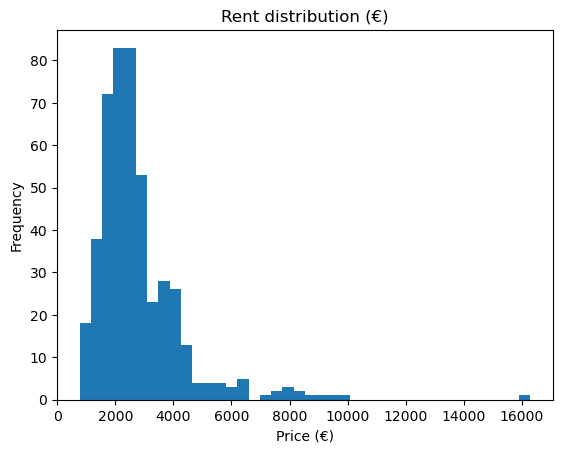

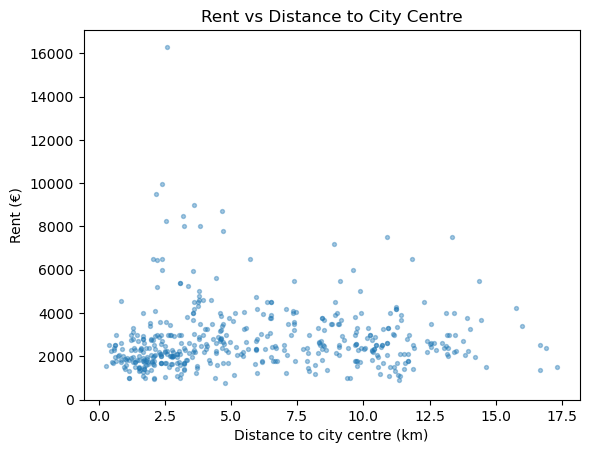

In [18]:
import matplotlib.pyplot as plt

# Rent distribution
df_clean["Price (€)"].plot(kind="hist", bins=40)
plt.title("Rent distribution (€)")
plt.xlabel("Price (€)")
plt.show()

# Distance vs Rent scatter (quick gradient check)
plt.scatter(df_clean["distance_to_city_centre_km"], df_clean["Price (€)"], s=8, alpha=0.4)
plt.xlabel("Distance to city centre (km)")
plt.ylabel("Rent (€)")
plt.title("Rent vs Distance to City Centre")
plt.show()


In [19]:
print("---- DATASET SANITY CHECK ----")

# 1. shapes
print("df_master:", df_master.shape)
print("df_clean :", df_clean.shape)

# 2. counts
print("Total rows in master :", len(df_master))
print("Good rows (clean)    :", len(df_clean))
print("Bad geocodes flagged :", df_master['bad_geocode'].sum())

# 3. basic rent sanity
print("\nRent (€) stats:")
print(df_clean["Price (€)"].describe())

# 4. feature sanity
for col in ["distance_to_city_centre_km","price_per_bedroom",
            "energy_monthly_estimate","effective_monthly_cost"]:
    if col in df_clean.columns:
        print(f"\n{col}:")
        print(df_clean[col].describe())

# 5. missing values
missing = df_clean.isna().sum().sort_values(ascending=False)
print("\nColumns with missing values:")
print(missing[missing>0])

# 6. quick preview
print("\nSample rows:")
display(df_clean.sample(5, random_state=42)[["Address","Price (€)","Bedrooms","BER Rating",
                                             "distance_to_city_centre_km","price_per_bedroom",
                                             "energy_monthly_estimate","effective_monthly_cost"]])


---- DATASET SANITY CHECK ----
df_master: (1134, 24)
df_clean : (470, 30)
Total rows in master : 1134
Good rows (clean)    : 470
Bad geocodes flagged : 664

Rent (€) stats:
count      470.000000
mean      2774.212766
std       1527.321075
min        769.000000
25%       1847.750000
50%       2400.000000
75%       3200.000000
max      16300.000000
Name: Price (€), dtype: float64

distance_to_city_centre_km:
count    470.000000
mean       5.879484
std        4.062231
min        0.283682
25%        2.349470
50%        4.627653
75%        9.410537
max       17.320305
Name: distance_to_city_centre_km, dtype: float64

price_per_bedroom:
count     470.000000
mean     1342.670213
std       503.246962
min       275.000000
25%       998.250000
50%      1235.000000
75%      1600.000000
max      3400.000000
Name: price_per_bedroom, dtype: float64

energy_monthly_estimate:
count    287.000000
mean     170.125436
std       92.232821
min       13.000000
25%      115.000000
50%      166.000000
75%    

,Address,Price (€),Bedrooms,BER Rating,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost
55,"Francis St, Dublin 8",1946.0,1.0,BER Exempt,1.303739,1946.0,NaN,NaN
73,"Ailesbury Oaks, Ballsbridge, Dublin 4",2800.0,2.0,C1,4.330318,1400.0,166.0,2966.0
33,"Kilmainham Square, The Old Chocolate Factory, ...",1829.0,2.0,BER Exempt,3.347398,914.0,NaN,NaN
446,"77 Grosvenor Square Rathmines Dublin 6, Rathga...",1600.0,1.0,D1,3.065612,1600.0,248.0,1848.0
425,"South Circular Road, Dublin 8",1410.0,1.0,BER Exempt,3.240116,1410.0,NaN,NaN


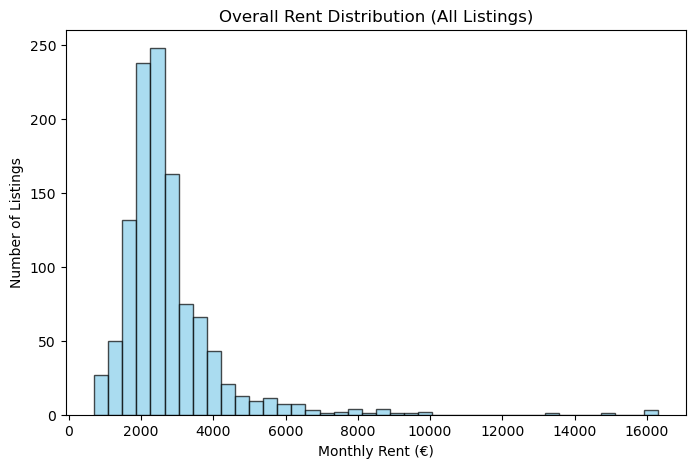

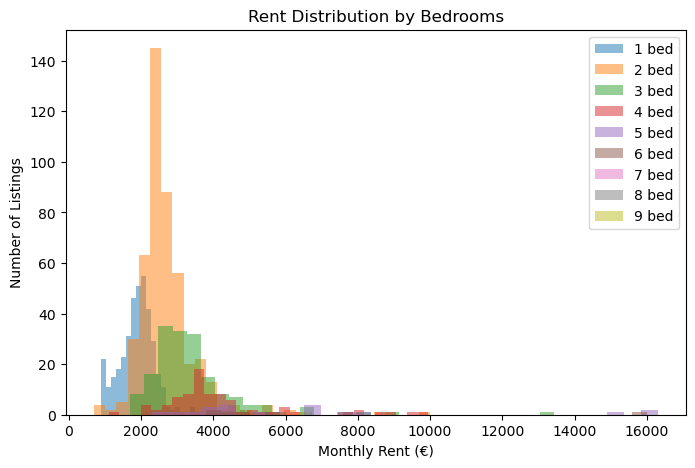

In [20]:
plt.figure(figsize=(8,5))
df_master["Price (€)"].plot(kind="hist", bins=40, alpha=0.7, color="skyblue", edgecolor="black")
plt.title("Overall Rent Distribution (All Listings)")
plt.xlabel("Monthly Rent (€)")
plt.ylabel("Number of Listings")
plt.show()

# 2. Rent distribution by bedrooms
plt.figure(figsize=(8,5))
for beds in sorted(df_master["Bedrooms"].dropna().unique()):
    subset = df_master[df_master["Bedrooms"] == beds]
    subset["Price (€)"].plot(kind="hist", bins=30, alpha=0.5, label=f"{int(beds)} bed")

plt.title("Rent Distribution by Bedrooms")
plt.xlabel("Monthly Rent (€)")
plt.ylabel("Number of Listings")
plt.legend()
plt.show()

                count_listings  avg_price  median_price  avg_bedrooms
district_group                                                       
Even                       574    2939.61        2540.0          2.03
Odd                        340    2355.21        2300.0          1.89


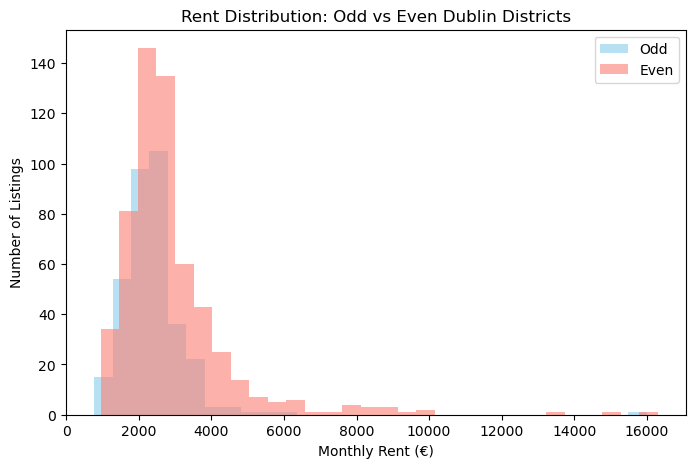

In [21]:
import re

# --- extract Dublin postal district numbers from Address ---
def extract_dublin_district(addr):
    if pd.isna(addr):
        return None
    m = re.search(r"Dublin\s*(\d+)", str(addr))
    if m:
        return int(m.group(1))
    return None

df_master["dublin_district"] = df_master["Address"].apply(extract_dublin_district)

# --- classify odd vs even ---
df_master["district_group"] = df_master["dublin_district"].apply(
    lambda x: "Odd" if pd.notna(x) and x % 2 == 1 else ("Even" if pd.notna(x) else None)
)

# --- summary stats ---
summary = df_master.groupby("district_group").agg(
    count_listings=("Price (€)", "count"),
    avg_price=("Price (€)", "mean"),
    median_price=("Price (€)", "median"),
    avg_bedrooms=("Bedrooms", "mean")
).round(2)

print(summary)

# --- histogram of rents by odd vs even ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for group, color in [("Odd","skyblue"), ("Even","salmon")]:
    subset = df_master[df_master["district_group"] == group]
    plt.hist(subset["Price (€)"], bins=30, alpha=0.6, label=group, color=color)

plt.title("Rent Distribution: Odd vs Even Dublin Districts")
plt.xlabel("Monthly Rent (€)")
plt.ylabel("Number of Listings")
plt.legend()
plt.show()


                count_listings  avg_price_per_bedroom  \
district_group                                          
Even                       574                1581.85   
Odd                        340                1401.10   

                median_price_per_bedroom  
district_group                            
Even                             1409.75  
Odd                              1287.75  


<Figure size 600x500 with 0 Axes>

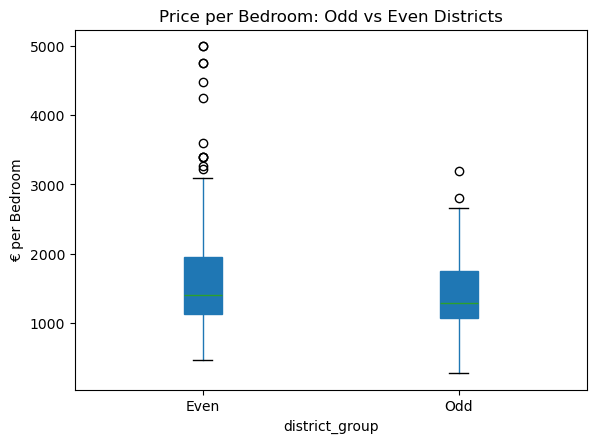

In [22]:
# --- add price per bedroom ---
df_master["price_per_bedroom"] = np.where(
    (df_master["Bedrooms"].notna()) & (df_master["Bedrooms"] > 0),
    df_master["Price (€)"] / df_master["Bedrooms"],
    np.nan
)

# --- summary by odd/even ---
summary_ppb = df_master.groupby("district_group").agg(
    count_listings=("price_per_bedroom", "count"),
    avg_price_per_bedroom=("price_per_bedroom", "mean"),
    median_price_per_bedroom=("price_per_bedroom", "median")
).round(2)

print(summary_ppb)

# --- visualize: boxplot of price_per_bedroom ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
df_master.boxplot(column="price_per_bedroom", by="district_group", grid=False, patch_artist=True)
plt.title("Price per Bedroom: Odd vs Even Districts")
plt.suptitle("")  # remove automatic pandas title
plt.ylabel("€ per Bedroom")
plt.show()


In [23]:
print(df_master.columns.tolist())

['URL', 'Address', 'Bedrooms', 'Bathrooms', 'Property Type', 'BER Rating', 'Price (€)', 'lat', 'lon', 'nearest_park_km_y', 'nearest_beach_km_y', 'nearest_gym_km_y', 'nearest_supermarket_km_y', 'nearest_bus_stop_km_y', 'nearest_rail_station_km_y', 'nearest_tram_stop_km_y', 'nearest_park_name_y', 'nearest_beach_name_y', 'nearest_gym_name_y', 'nearest_supermarket_name_y', 'nearest_bus_stop_name_y', 'nearest_rail_station_name_y', 'nearest_tram_stop_name_y', 'bad_geocode', 'dublin_district', 'district_group', 'price_per_bedroom']


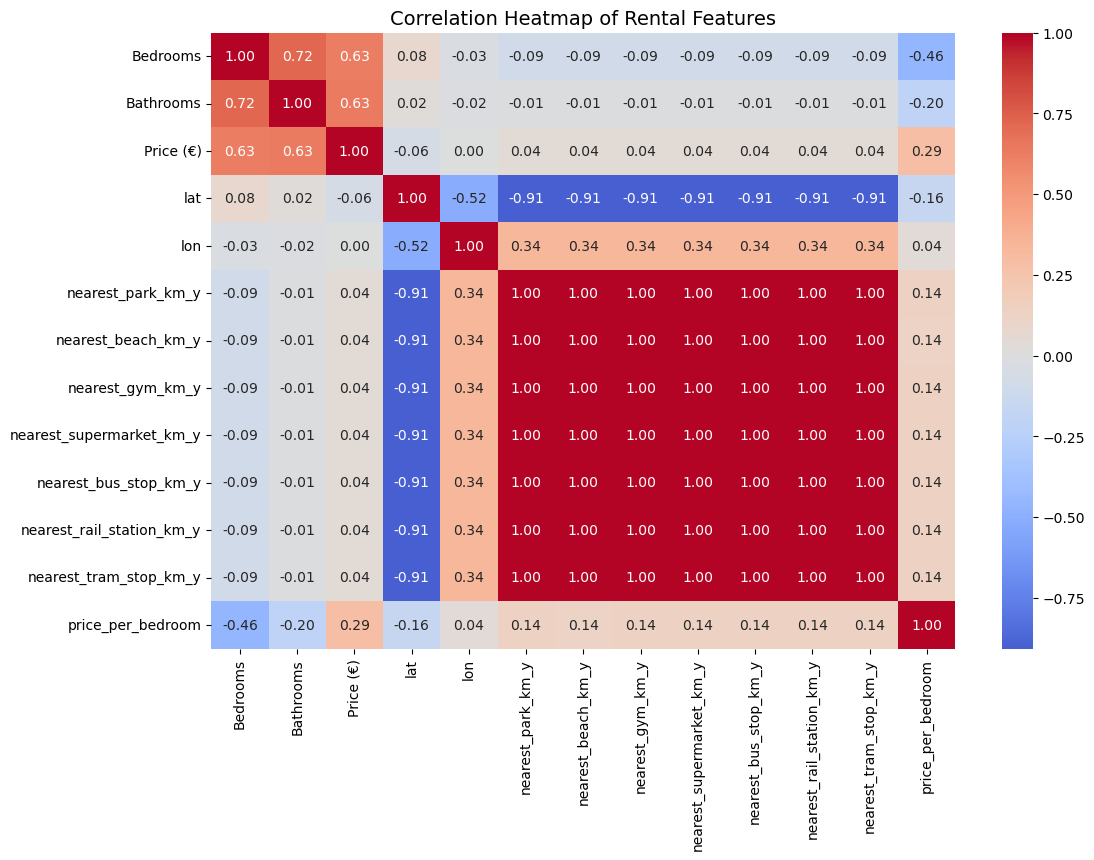

In [24]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# pick numeric columns (drop NaNs automatically)
num_cols = ["Bedrooms","Bathrooms","Price (€)","lat","lon",
            "nearest_park_km_y","nearest_beach_km_y","nearest_gym_km_y",
            "nearest_supermarket_km_y","nearest_bus_stop_km_y",
            "nearest_rail_station_km_y","nearest_tram_stop_km_y",
            "price_per_bedroom"]

corr = df_master[num_cols].dropna().corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Rental Features", fontsize=14)
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# pick a small feature set for baseline model
features = ["Bedrooms", "Bathrooms", "lat", "lon"]
X = df_master[features]
y = df_master["Price (€)"]

# drop rows with missing values
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predictions
y_pred = lr.predict(X_test)

# evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression")
print("Features:", features)
print("RMSE:", round(rmse,2))
print("R²:", round(r2,2))

# coefficients
coeffs = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_})
print(coeffs)


Baseline Linear Regression
Features: ['Bedrooms', 'Bathrooms', 'lat', 'lon']
RMSE: 909.76
R²: 0.41
     Feature  Coefficient
0   Bedrooms   476.408257
1  Bathrooms   734.398377
2        lat   -10.662603
3        lon    -1.595387


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# 1) BER encoding
ber_map = {
    "A1":1,"A2":2,"A3":3,
    "B1":4,"B2":5,"B3":6,
    "C1":7,"C2":8,"C3":9,
    "D1":10,"D2":11,
    "E1":12,"E2":13,
    "F":14,"G":15
}
df_master["BER_encoded"] = df_master["BER Rating"].map(ber_map)

# 2) Feature set
features = [
    "Bedrooms","Bathrooms","lat","lon","BER_encoded",
    "nearest_tram_stop_km_y","nearest_rail_station_km_y",
    "nearest_bus_stop_km_y","nearest_supermarket_km_y",
    "nearest_gym_km_y","nearest_park_km_y","nearest_beach_km_y"
]

X = df_master[features]
y = df_master["Price (€)"]

# 3) Drop rows with any NA in features/target
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# 5) Fit & predict
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# 6) Evaluation (version-proof RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Expanded Linear Regression")
print("Features used:", features)
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 2))

# 7) Coefficients
coeffs = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_.round(2)})
print("\nCoefficients (€/unit):")
print(coeffs.sort_values("Coefficient", ascending=False))


Expanded Linear Regression
Features used: ['Bedrooms', 'Bathrooms', 'lat', 'lon', 'BER_encoded', 'nearest_tram_stop_km_y', 'nearest_rail_station_km_y', 'nearest_bus_stop_km_y', 'nearest_supermarket_km_y', 'nearest_gym_km_y', 'nearest_park_km_y', 'nearest_beach_km_y']
RMSE: 634.48
R²: 0.43

Coefficients (€/unit):
                      Feature  Coefficient
0                    Bedrooms       672.77
1                   Bathrooms       381.66
10          nearest_park_km_y       160.68
9            nearest_gym_km_y       145.04
8    nearest_supermarket_km_y        66.09
6   nearest_rail_station_km_y        22.60
2                         lat        -4.49
3                         lon        -5.60
4                 BER_encoded       -59.07
11         nearest_beach_km_y      -111.58
5      nearest_tram_stop_km_y      -129.77
7       nearest_bus_stop_km_y      -152.97


RandomForest Regressor
RMSE: 758.64
R²: 0.19


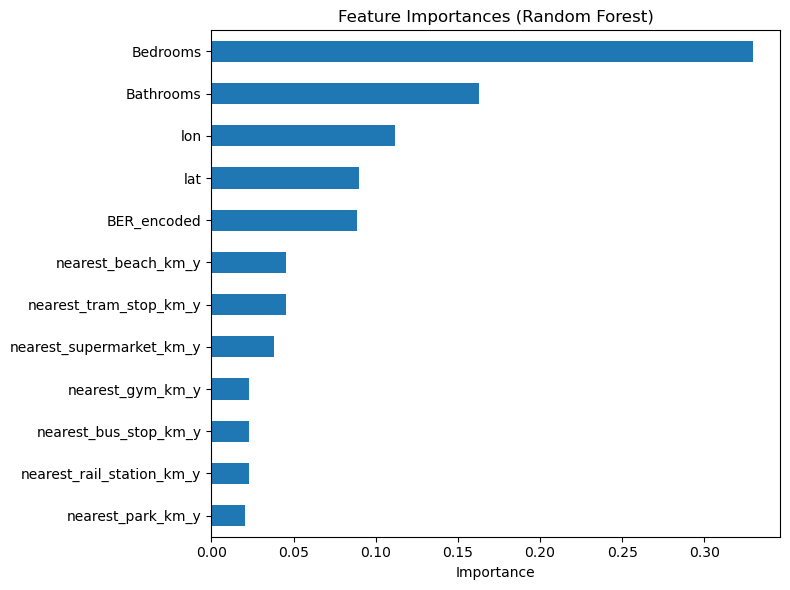

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use the same X, y, mask as above (so you can run this right after)
X_rf, y_rf = X.copy(), y.copy()

Xtr, Xte, ytr, yte = train_test_split(
    X_rf, y_rf, test_size=0.20, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, ytr)
pred = rf.predict(Xte)

mse = mean_squared_error(yte, pred)
rmse = np.sqrt(mse)
r2 = r2_score(yte, pred)

print("RandomForest Regressor")
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 2))

# Feature importance plot
imp = pd.Series(rf.feature_importances_, index=X_rf.columns).sort_values(ascending=True)
plt.figure(figsize=(8,6))
imp.plot(kind="barh")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Added columns: min_transit_km, min_amenity_km, within_1km_transit, within_500m_transit
       min_transit_km  min_amenity_km
count      951.000000      951.000000
mean      2404.649838     2400.190762
std       3878.362183     3877.645418
min          0.140000        0.124000
25%          3.121500        1.775000
50%         17.741000       14.635000
75%       5051.153000     5048.430500
max      18923.192000    18919.896000

Linear Regression (with composite distances)
Features: ['Bedrooms', 'Bathrooms', 'lat', 'lon', 'BER_encoded', 'min_transit_km', 'min_amenity_km']
RMSE: 625.94
R²: 0.45
          Feature  Coefficient
0        Bedrooms       612.75
1       Bathrooms       370.35
5  min_transit_km        10.96
3             lon        -2.44
6  min_amenity_km       -11.01
2             lat       -23.15
4     BER_encoded       -59.57

RandomForest Regressor (with composite distances)
RMSE: 772.59
R²: 0.16


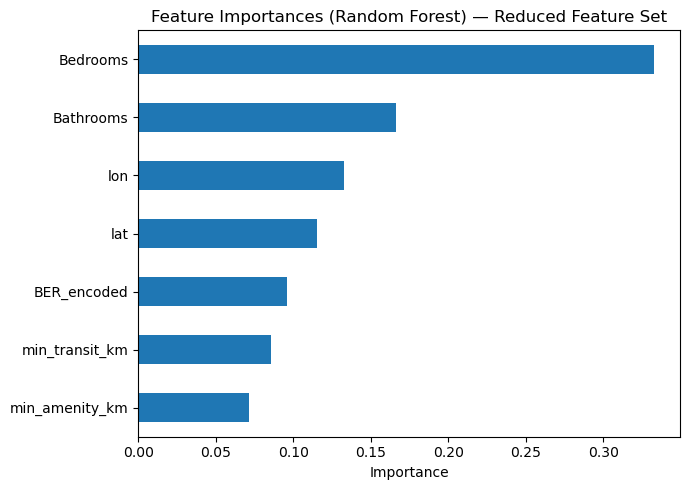

In [28]:
# --- 1) Composite distance features (non-destructive) ---
# These NEW columns leave all your existing columns untouched.
transit_cols = ["nearest_tram_stop_km_y","nearest_rail_station_km_y","nearest_bus_stop_km_y"]
amenity_cols = ["nearest_supermarket_km_y","nearest_gym_km_y","nearest_park_km_y","nearest_beach_km_y"]

df_master["min_transit_km"] = df_master[transit_cols].min(axis=1, skipna=True)
df_master["min_amenity_km"] = df_master[amenity_cols].min(axis=1, skipna=True)

# Optional handy flags for later EDA
df_master["within_1km_transit"] = (df_master["min_transit_km"] <= 1.0)
df_master["within_500m_transit"] = (df_master["min_transit_km"] <= 0.5)

print("Added columns: min_transit_km, min_amenity_km, within_1km_transit, within_500m_transit")
print(df_master[["min_transit_km","min_amenity_km"]].describe())

# --- 2) Ensure BER encoding exists (non-destructive) ---
ber_map = {"A1":1,"A2":2,"A3":3,"B1":4,"B2":5,"B3":6,"C1":7,"C2":8,"C3":9,"D1":10,"D2":11,"E1":12,"E2":13,"F":14,"G":15}
if "BER_encoded" not in df_master.columns:
    df_master["BER_encoded"] = df_master["BER Rating"].map(ber_map)

# --- 3) Re-run Linear Regression with reduced collinearity ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features_reduced = [
    "Bedrooms","Bathrooms","lat","lon","BER_encoded",
    "min_transit_km","min_amenity_km"
]

X = df_master[features_reduced]
y = df_master["Price (€)"]

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression (with composite distances)")
print("Features:", features_reduced)
print("RMSE:", round(rmse, 2))
print("R²:", round(r2, 2))
print(pd.DataFrame({"Feature": features_reduced, "Coefficient": lr.coef_.round(2)})
      .sort_values("Coefficient", ascending=False))

# --- 4) Random Forest for non-linear effects + importances ---
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, pred))
r2_rf = r2_score(y_test, pred)

print("\nRandomForest Regressor (with composite distances)")
print("RMSE:", round(rmse_rf, 2))
print("R²:", round(r2_rf, 2))

imp = pd.Series(rf.feature_importances_, index=features_reduced).sort_values(ascending=True)
plt.figure(figsize=(7,5))
imp.plot(kind="barh")
plt.title("Feature Importances (Random Forest) — Reduced Feature Set")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


            listings  avg_price  median_price  avg_ppb
BER_cat                                               
E2                12    4114.67        3125.0  1322.74
A2               185    3146.95        2575.0  1794.15
A1                30    2979.73        2793.0  1596.56
B3                61    2941.25        2650.0  1402.93
C1                88    2816.65        2500.0  1338.86
A3                93    2800.98        2550.0  1688.67
C3                82    2774.40        2497.5  1307.18
E1                15    2748.93        2300.0  1322.09
BER Exempt       216    2682.40        2100.0  1534.29
B1                30    2635.67        2475.0  1645.63
B2                49    2635.59        2616.0  1477.91
C2                74    2631.86        2435.0  1314.59
D2                44    2445.32        2497.5  1353.06
F                  7    2377.86        1845.0  1577.86
Missing           76    2274.75        2200.0  1018.14
D1                56    2231.25        2216.5  1392.54
D         

<Figure size 1000x600 with 0 Axes>

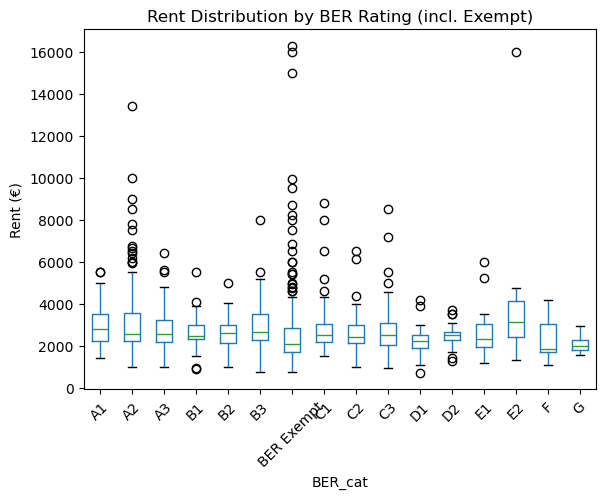

In [29]:
# create a clean BER category column
df_master["BER_cat"] = df_master["BER Rating"].fillna("Missing")

# summary stats: count, mean, median, price/bedroom
ber_summary = df_master.groupby("BER_cat").agg(
    listings=("Price (€)", "count"),
    avg_price=("Price (€)", "mean"),
    median_price=("Price (€)", "median"),
    avg_ppb=("price_per_bedroom","mean")
).round(2).sort_values("avg_price", ascending=False)

print(ber_summary)

# compare BER vs Exempt directly
exempt_vs_ber = df_master[df_master["BER_cat"].isin(["BER Exempt","A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","E1","E2","F","G"])]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
exempt_vs_ber.boxplot(column="Price (€)", by="BER_cat", grid=False, rot=45)
plt.title("Rent Distribution by BER Rating (incl. Exempt)")
plt.suptitle("")
plt.ylabel("Rent (€)")
plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ---- ROI helper for BER upgrades ----
BER_ORDER = ["A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","E1","E2","F","G"]
BER_INDEX = {b:i for i,b in enumerate(BER_ORDER)}

def bands_between(start_ber, target_ber):
    """Positive if target is better (to the left in BER_ORDER)."""
    s = normalize_ber(start_ber)
    t = normalize_ber(target_ber)
    if s is None or t is None: 
        return np.nan
    return BER_INDEX[s] - BER_INDEX[t]

def monthly_bill(ber, size_m2=70.0, scenario="mixed"):
    """Your existing monthly estimate (usage-only); returns np.nan if BER missing/exempt."""
    return monthly_energy_cost_eur(ber, size_m2=size_m2, scenario=scenario)

def ber_upgrade_roi(start_ber, target_ber, *,
                    size_m2=70.0,
                    scenario="mixed",        # "mixed" or "electric"
                    upgrade_cost=10000,      # € total project cost (net of grant)
                    rent_coef_per_band=60.0, # €/month per band from your regression
                    show_plot=True):
    """
    Returns a dict of ROI metrics + optional mini bar chart.
    """
    band_improvement = bands_between(start_ber, target_ber)  # e.g., D2->C2 = +3 (11->8)
    rent_uplift = band_improvement * float(rent_coef_per_band) if np.isfinite(band_improvement) else np.nan

    start_bill = monthly_bill(start_ber, size_m2=size_m2, scenario=scenario)
    target_bill = monthly_bill(target_ber, size_m2=size_m2, scenario=scenario)
    bill_saving = (start_bill - target_bill) if (np.isfinite(start_bill) and np.isfinite(target_bill)) else np.nan

    total_monthly_benefit = np.nansum([rent_uplift, bill_saving])  # ignores NaN terms
    payback_months = (upgrade_cost / total_monthly_benefit) if (total_monthly_benefit and total_monthly_benefit > 0) else np.nan
    payback_years = payback_months / 12 if np.isfinite(payback_months) else np.nan

    result = {
        "start_ber": start_ber,
        "target_ber": target_ber,
        "bands_improved": band_improvement,
        "rent_uplift_per_month": None if np.isnan(rent_uplift) else round(rent_uplift, 0),
        "bill_saving_per_month": None if np.isnan(bill_saving) else round(bill_saving, 0),
        "total_benefit_per_month": None if np.isnan(total_monthly_benefit) else round(total_monthly_benefit, 0),
        "upgrade_cost": upgrade_cost,
        "payback_months": None if np.isnan(payback_months) else round(payback_months, 1),
        "payback_years": None if np.isnan(payback_years) else round(payback_years, 2),
        "assumptions": {
            "size_m2": size_m2,
            "scenario": scenario,
            "rent_coef_per_band": rent_coef_per_band
        }
    }

    # Pretty print
    print("=== BER Upgrade ROI ===")
    print(f"From {start_ber} → {target_ber} | Bands improved: {band_improvement if np.isfinite(band_improvement) else 'n/a'}")
    print(f"Rent uplift/month: €{result['rent_uplift_per_month'] if result['rent_uplift_per_month'] is not None else 'n/a'}")
    print(f"Bill saving/month: €{result['bill_saving_per_month'] if result['bill_saving_per_month'] is not None else 'n/a'}")
    print(f"Total benefit/month: €{result['total_benefit_per_month'] if result['total_benefit_per_month'] is not None else 'n/a'}")
    print(f"Upgrade cost: €{upgrade_cost:,}")
    print(f"Simple payback: {result['payback_months']} months ({result['payback_years']} years)")
    print(f"Assumptions → size: {size_m2} m², heating: {scenario}, rent €/band: {rent_coef_per_band}")

    if show_plot and (result["rent_uplift_per_month"] is not None or result["bill_saving_per_month"] is not None):
        vals = [
            result["rent_uplift_per_month"] or 0,
            result["bill_saving_per_month"] or 0,
            result["total_benefit_per_month"] or 0
        ]
        labels = ["Rent uplift", "Bill saving", "Total/month"]
        plt.figure(figsize=(5,3))
        plt.bar(labels, vals)
        plt.title(f"Monthly Impact: {start_ber} → {target_ber}")
        plt.ylabel("€ per month")
        plt.tight_layout()
        plt.show()

    return result


In [31]:
# Make sure plots show in notebook
%matplotlib inline

=== BER Upgrade ROI ===
From D2 → C2 | Bands improved: 3
Rent uplift/month: €180.0
Bill saving/month: €95.0
Total benefit/month: €275.0
Upgrade cost: €12,000
Simple payback: 43.7 months (3.64 years)
Assumptions → size: 70 m², heating: mixed, rent €/band: 60


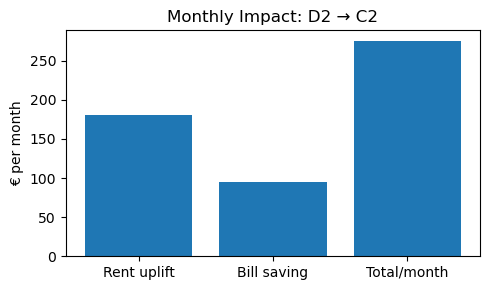

In [32]:
# Example 1: D2 → C2, €12k net, 70 m², mixed heating
res1 = ber_upgrade_roi("D2", "C2", upgrade_cost=12000, size_m2=70, scenario="mixed", rent_coef_per_band=60)


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# helper: clean BER categories for plotting
def ber_bucket(s):
    if pd.isna(s): return "Missing"
    s = str(s).strip()
    if s.lower().startswith("ber exempt"): return "BER Exempt"
    return s

# helper: compress into Rated vs Exempt vs Missing
def rated_group(s):
    s = ber_bucket(s)
    if s in ["BER Exempt","Missing"]: return s
    # map A1..G → their first letter A..G
    letter = s[0].upper()
    return "Rated (A–C)" if letter in ["A","B","C"] else "Rated (D–G)"

# (optional) compute effective monthly cost on the fly if missing and function exists
def ensure_effective_monthly(df):
    if "effective_monthly_cost" in df.columns:
        return df
    # try to compute from monthly_energy_cost_eur if the helper exists in your notebook
    if "monthly_energy_cost_eur" in globals():
        tmp = df.copy()
        tmp["energy_monthly_estimate_tmp"] = tmp["BER Rating"].apply(
            lambda x: monthly_energy_cost_eur(x, scenario="mixed", size_m2=70.0)
        )
        tmp["effective_monthly_cost"] = tmp["Price (€)"] + tmp["energy_monthly_estimate_tmp"]
        return tmp
    # fallback: just mirror rent (so chart 3 still renders)
    tmp = df.copy()
    tmp["effective_monthly_cost"] = tmp["Price (€)"]
    return tmp


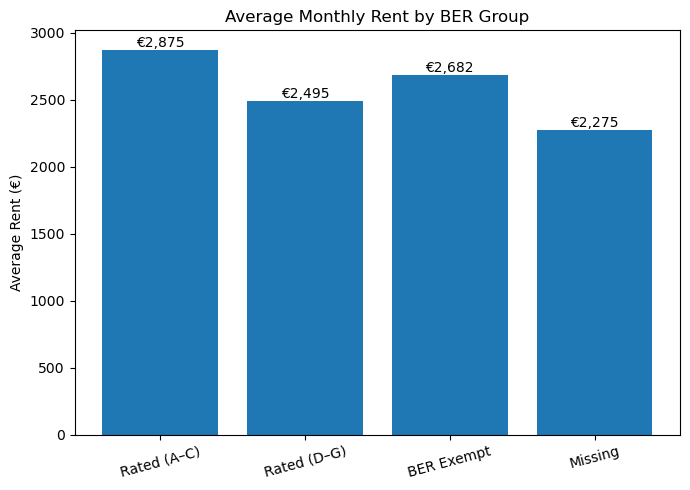

In [34]:
dfp = df_master.copy()
dfp["BER_group"] = dfp["BER Rating"].apply(rated_group)

agg = dfp.groupby("BER_group")["Price (€)"].mean().reindex(["Rated (A–C)","Rated (D–G)","BER Exempt","Missing"])
agg = agg.dropna()

plt.figure(figsize=(7,5))
plt.bar(agg.index, agg.values)
plt.title("Average Monthly Rent by BER Group")
plt.ylabel("Average Rent (€)")
plt.xticks(rotation=15)
for i, v in enumerate(agg.values):
    plt.text(i, v, f"€{v:,.0f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


C:\Users\Lee\AppData\Local\Temp\ipykernel_18708\918988989.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=present, showfliers=False)


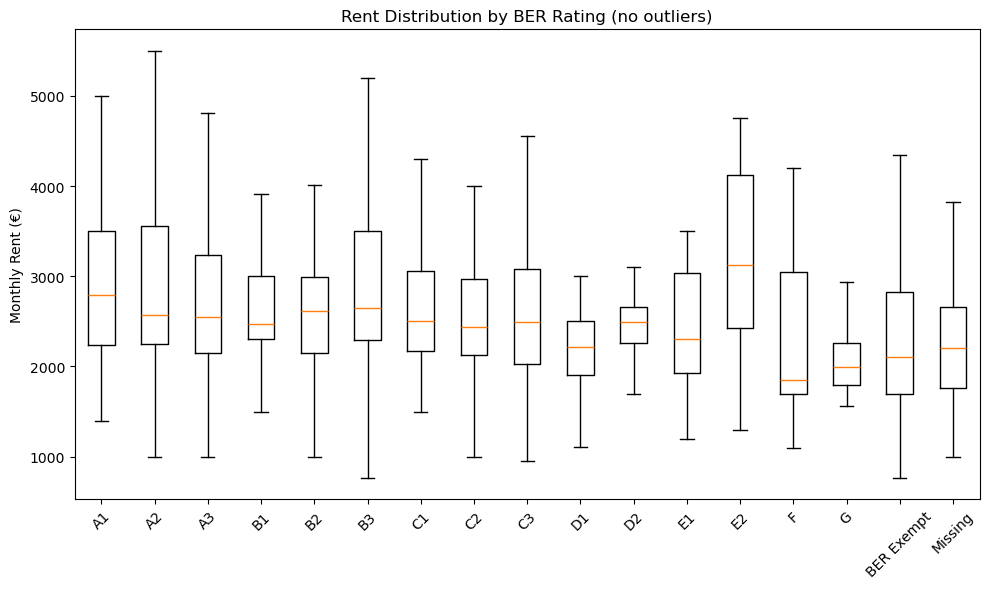

In [35]:
dfp = df_master.copy()
dfp["BER_cat"] = dfp["BER Rating"].apply(ber_bucket)

# Order BERs for nicer x-axis
order = ["A1","A2","A3","B1","B2","B3","C1","C2","C3",
         "D1","D2","E1","E2","F","G","BER Exempt","Missing"]
present = [c for c in order if c in dfp["BER_cat"].unique()]

data = [dfp.loc[dfp["BER_cat"]==c, "Price (€)"].dropna().values for c in present]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=present, showfliers=False)
plt.title("Rent Distribution by BER Rating (no outliers)")
plt.ylabel("Monthly Rent (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


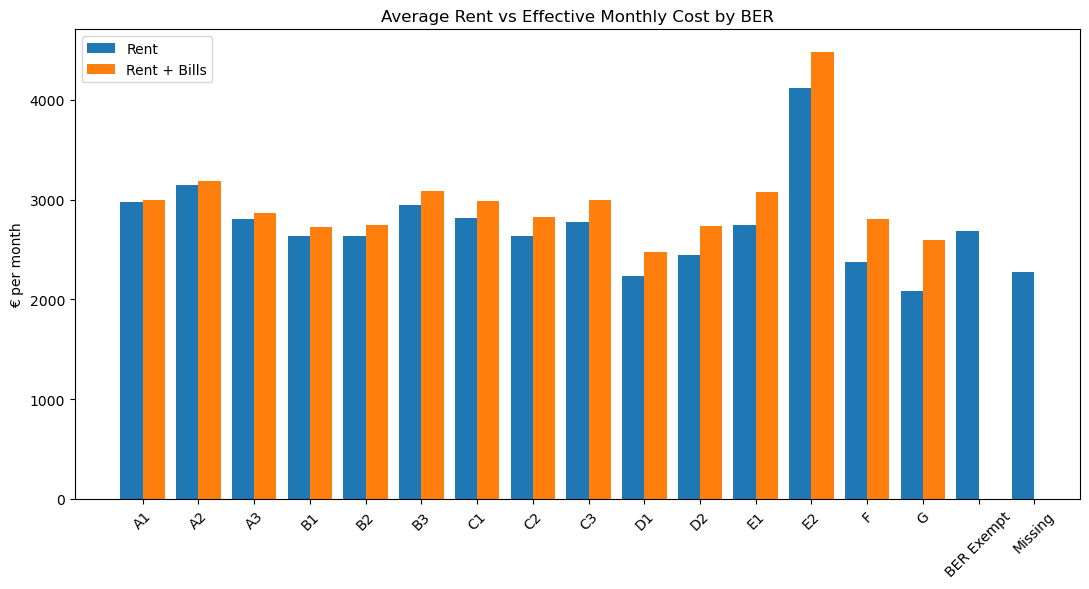

In [36]:
dfp = ensure_effective_monthly(df_master)
dfp["BER_cat"] = dfp["BER Rating"].apply(ber_bucket)

order = ["A1","A2","A3","B1","B2","B3","C1","C2","C3",
         "D1","D2","E1","E2","F","G","BER Exempt","Missing"]
present = [c for c in order if c in dfp["BER_cat"].unique()]

avg_rent = dfp.groupby("BER_cat")["Price (€)"].mean().reindex(present)
avg_eff  = dfp.groupby("BER_cat")["effective_monthly_cost"].mean().reindex(present)

x = np.arange(len(present))
w = 0.4

plt.figure(figsize=(11,6))
plt.bar(x - w/2, avg_rent.values, width=w, label="Rent")
plt.bar(x + w/2, avg_eff.values,  width=w, label="Rent + Bills")
plt.title("Average Rent vs Effective Monthly Cost by BER")
plt.ylabel("€ per month")
plt.xticks(x, present, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


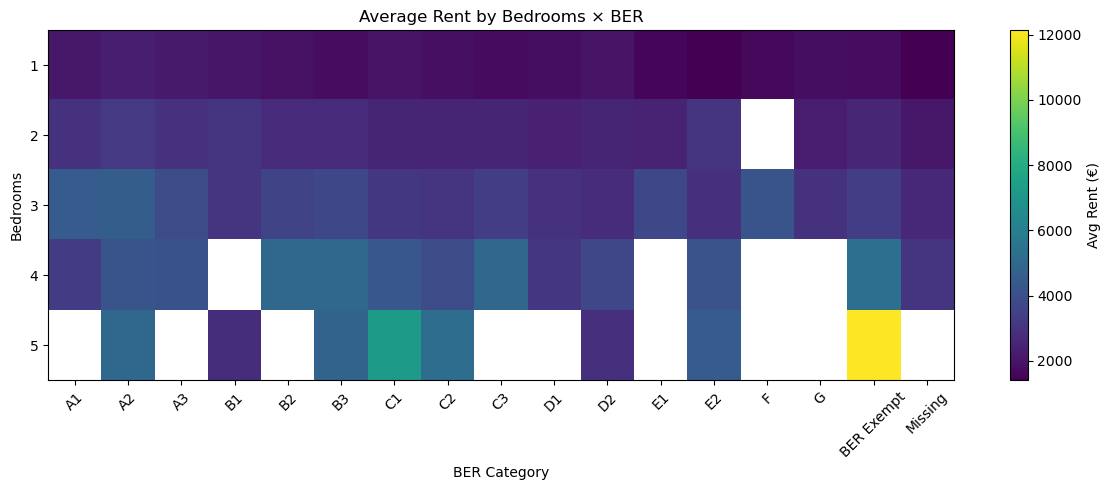

In [37]:
dfp = df_master.copy()
dfp["BER_cat"] = dfp["BER Rating"].apply(ber_bucket)
dfp["Bedrooms_int"] = pd.to_numeric(dfp["Bedrooms"], errors="coerce").astype("Int64")

# choose bedroom bands present
beds = sorted([int(x) for x in dfp["Bedrooms_int"].dropna().unique() if x<=5])  # cap at 5 for clarity
bers = ["A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","E1","E2","F","G","BER Exempt","Missing"]
bers = [b for b in bers if b in dfp["BER_cat"].unique()]

pivot = dfp.pivot_table(index="Bedrooms_int", columns="BER_cat", values="Price (€)", aggfunc="mean")
pivot = pivot.reindex(index=beds, columns=bers)

plt.figure(figsize=(12,5))
plt.imshow(pivot.values, aspect="auto", interpolation="nearest")
plt.colorbar(label="Avg Rent (€)")
plt.xticks(range(len(bers)), bers, rotation=45)
plt.yticks(range(len(beds)), beds)
plt.title("Average Rent by Bedrooms × BER")
plt.xlabel("BER Category")
plt.ylabel("Bedrooms")
plt.tight_layout()
plt.show()


Scenario: D2 → C2 | Bands: 3
Rent uplift/month: €180.0
Bill saving/month: €95.0
Total benefit/month: €275.0


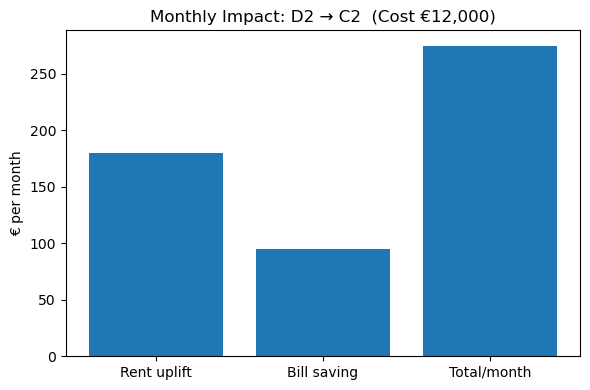

In [38]:
# configure your scenario here
start_ber = "D2"
target_ber = "C2"
upgrade_cost = 12000
size_m2 = 70
rent_coef_per_band = 60.0  # €/month per band (from your regression)

# compute bands improved
BER_ORDER = ["A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","E1","E2","F","G"]
idx = {b:i for i,b in enumerate(BER_ORDER)}
def norm(b): 
    b2 = ber_bucket(b)
    return b2 if b2 in idx else None

bands = (idx[norm(start_ber)] - idx[norm(target_ber)]) if (norm(start_ber) and norm(target_ber)) else np.nan
rent_uplift = bands * rent_coef_per_band if np.isfinite(bands) else np.nan

# bill saving: use your helper if available; else set to np.nan
if "monthly_energy_cost_eur" in globals():
    start_bill = monthly_energy_cost_eur(start_ber, size_m2=size_m2, scenario="mixed")
    target_bill = monthly_energy_cost_eur(target_ber, size_m2=size_m2, scenario="mixed")
    bill_saving = (start_bill - target_bill) if (pd.notna(start_bill) and pd.notna(target_bill)) else np.nan
else:
    bill_saving = np.nan

total = np.nansum([rent_uplift, bill_saving])

print(f"Scenario: {start_ber} → {target_ber} | Bands: {bands}")
print(f"Rent uplift/month: €{None if np.isnan(rent_uplift) else round(rent_uplift,0)}")
print(f"Bill saving/month: €{None if np.isnan(bill_saving) else round(bill_saving,0)}")
print(f"Total benefit/month: €{None if np.isnan(total) else round(total,0)}")

plt.figure(figsize=(6,4))
vals = [
    0 if np.isnan(rent_uplift) else rent_uplift,
    0 if np.isnan(bill_saving) else bill_saving,
    0 if np.isnan(total) else total
]
labels = ["Rent uplift","Bill saving","Total/month"]
plt.bar(labels, vals)
plt.title(f"Monthly Impact: {start_ber} → {target_ber}  (Cost €{upgrade_cost:,})")
plt.ylabel("€ per month")
plt.tight_layout()
plt.show()


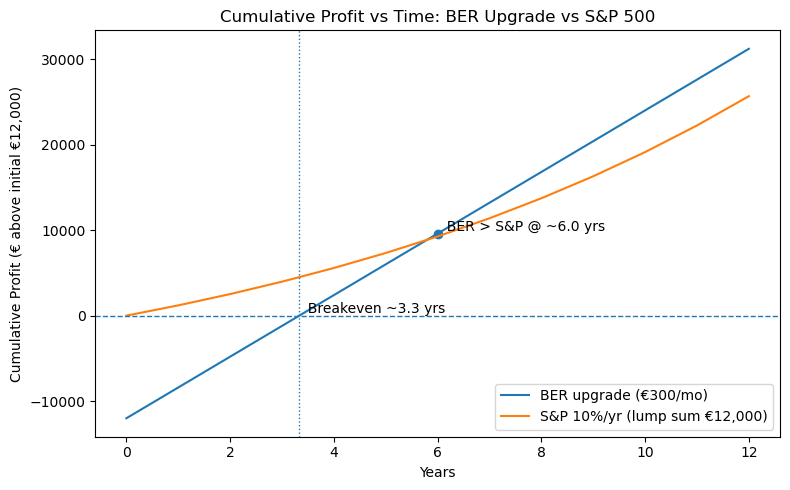

=== Scenario Summary ===
Initial cost (upgrade): €12,000
Monthly gain: €300  →  Annual: €3,600
BER simple annual yield on cost: 30.0%
BER breakeven: ~3.3 years
BER cumulative profit exceeds S&P after ~6.0 years (at 10%/yr for S&P).


In [39]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters (tweak these) ---
initial_cost = 12_000          # € to upgrade from C -> B (example)
monthly_gain = 300             # €/month after upgrade (rent uplift + bill saving)
sp_return = 0.10               # S&P 500 assumed annual return (10%)
years = 12                     # horizon to plot

# --- Derived ---
annual_gain = monthly_gain * 12                   # €/year from BER upgrade
t = np.arange(0, years + 1, 1, dtype=float)      # 0..years

# Cumulative profit (above the initial 12k) for each strategy
# 1) BER upgrade: you spend 12k up front, then collect annual_gain each year
ber_profit = annual_gain * t - initial_cost

# 2) S&P 500: invest 12k; cumulative profit is growth above principal
sp_profit = initial_cost * ((1 + sp_return)**t - 1)

# Breakeven for BER upgrade (when cashflows cover initial)
breakeven_years = initial_cost / annual_gain if annual_gain > 0 else np.nan

# Simple cash-on-cash annual yield for BER
ber_yield_pct = (annual_gain / initial_cost) * 100  # e.g., 3600 / 12000 = 30%

# Find crossing point where one overtakes the other (first year where ber > sp)
cross_idx = np.where(ber_profit > sp_profit)[0]
cross_year = t[cross_idx[0]] if len(cross_idx) else None

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(t, ber_profit, label=f"BER upgrade (€{monthly_gain}/mo)")
plt.plot(t, sp_profit, label=f"S&P {int(sp_return*100)}%/yr (lump sum €{initial_cost:,})")
plt.axhline(0, linestyle="--", linewidth=1)

# annotate breakeven
if np.isfinite(breakeven_years):
    plt.axvline(breakeven_years, linestyle=":", linewidth=1)
    plt.text(breakeven_years, 0, f"  Breakeven ~{breakeven_years:.1f} yrs", va="bottom")

# annotate crossing (if any)
if cross_year is not None and cross_year > 0:
    y = ber_profit[int(cross_year)]
    plt.scatter([cross_year],[y])
    plt.text(cross_year, y, f"  BER > S&P @ ~{cross_year:.1f} yrs", va="bottom")

plt.title("Cumulative Profit vs Time: BER Upgrade vs S&P 500")
plt.xlabel("Years")
plt.ylabel("Cumulative Profit (€ above initial €{:,})".format(initial_cost))
plt.legend()
plt.tight_layout()
plt.show()

# --- Console summary ---
print("=== Scenario Summary ===")
print(f"Initial cost (upgrade): €{initial_cost:,}")
print(f"Monthly gain: €{monthly_gain:,}  →  Annual: €{annual_gain:,}")
print(f"BER simple annual yield on cost: {ber_yield_pct:.1f}%")
print(f"BER breakeven: ~{breakeven_years:.1f} years")
if cross_year is not None:
    print(f"BER cumulative profit exceeds S&P after ~{cross_year:.1f} years "
          f"(at {sp_return*100:.0f}%/yr for S&P).")
else:
    print(f"S&P cumulative profit never exceeds BER within {years} years (or vice versa); check the plot.")


In [40]:
def ber_roi_analysis(scenarios, monthly_benefit, horizon_years=6, sp_return=0.07):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt

    def find_sp_crossover_year(net_cost, monthly_total, sp_return, t_max=10.0, step=0.01, iters=40):
        if monthly_total <= 0 or net_cost <= 0: return None
        a = (monthly_total * 12.0) / net_cost
        def g(t): return a*t - (1.0 + sp_return)**t
        t, prev = 0.0, g(0.0); t += step
        while t <= t_max:
            val = g(t)
            if prev < 0 and val >= 0:
                lo, hi = t - step, t
                for _ in range(iters):
                    mid = (lo + hi)/2.0
                    (hi if g(mid) >= 0 else lo) == mid
                    if g(mid) >= 0: hi = mid
                    else: lo = mid
                return (lo + hi)/2.0
            prev = val; t += step
        return None

    t_years = np.arange(0, horizon_years+1, 1, dtype=float)
    rows = []
    plt.figure(figsize=(10,6))

    for sc in scenarios:
        start, target, label = sc["start"], sc["target"], sc["label"]
        net_cost = float(sc["gross_cost"] - sc["grant"])
        mb_total, mb_rent, mb_bill, bands = monthly_benefit(start, target)

        cum_profit = (mb_total * 12.0) * t_years - net_cost
        roi_pct = (cum_profit / net_cost) * 100.0
        plt.plot(t_years, roi_pct, label=f"{label} (net €{net_cost:,.0f})")

        breakeven_years = (net_cost / (mb_total * 12.0)) if mb_total > 0 else None
        sp_cross_years = find_sp_crossover_year(net_cost, mb_total, sp_return, t_max=horizon_years)

        rows.append({
            "Scenario": label,
            "Start→Target": f"{start}→{target}",
            "Bands": bands,
            "Net cost (€)": round(net_cost, 0),
            "Rent uplift €/mo": round(mb_rent or 0, 0),
            "Bill saving €/mo": round(mb_bill or 0, 0),
            "Total €/mo": round(mb_total or 0, 0),
            "Breakeven (yrs)": None if breakeven_years is None else float(f"{breakeven_years:.2f}"),
            "S&P Crossover (yrs)": None if sp_cross_years is None else float(f"{sp_cross_years:.2f}"),
            f"ROI @{horizon_years}y (%)": round(roi_pct[-1], 1)
        })

    sp_roi_pct = ((1.0 + sp_return)**t_years - 1.0) * 100.0
    plt.plot(t_years, sp_roi_pct, linestyle="--", label=f"S&P {int(sp_return*100)}% comp.")
    plt.axhline(0, linestyle=":", linewidth=1)
    plt.title(f"{horizon_years}-Year ROI: BER Upgrades vs S&P")
    plt.xlabel("Years"); plt.ylabel("ROI (%)")
    plt.legend(); plt.tight_layout(); plt.show()

    summary = pd.DataFrame(rows)
    sp_y = ((1 + sp_return)**horizon_years - 1) * 100
    summary = pd.concat([summary, pd.DataFrame([{
        "Scenario": f"S&P {int(sp_return*100)}% compounding",
        "Start→Target": "—", "Bands": "—",
        "Net cost (€)": "—", "Rent uplift €/mo": "—", "Bill saving €/mo": "—", "Total €/mo": "—",
        "Breakeven (yrs)": "—", "S&P Crossover (yrs)": "—",
        f"ROI @{horizon_years}y (%)": round(sp_y, 1)
    }])], ignore_index=True)

    return summary


In [41]:
# --- SETUP (run this first) ---

# Example BER upgrade scenarios (ballpark Irish retrofit costs & SEAI grants)
scenarios = [
    {"start": "E1", "target": "C1", "label": "E1 → C1 Upgrade",         "gross_cost": 40000, "grant": 8000},
    {"start": "D2", "target": "B2", "label": "D2 → B2 Upgrade",         "gross_cost": 50000, "grant": 8000},
    {"start": "C3", "target": "B1", "label": "C3 → B1 Deep Retrofit",   "gross_cost": 65000, "grant": 12000},
]

# Tunable assumptions (so you can calibrate quickly)
RENT_UPLIFT_PER_BAND = 30   # €/month gained per BER band improvement
BILL_SAVING_PER_BAND = 40   # €/month bills saved per BER band improvement

def monthly_benefit(start, target):
    """
    Returns: total €/mo, rent €/mo, bills €/mo, 'X band(s) improved'
    Steps are positive when target BER is better than start BER.
    """
    # worst -> best
    ber_bands = ["G", "F", "E2", "E1", "D2", "D1", "C3", "C2", "C1",
                 "B3", "B2", "B1", "A3", "A2", "A1"]

    if start not in ber_bands or target not in ber_bands:
        raise ValueError("Unknown BER band in start/target")

    # positive if moving to a better band
    steps = ber_bands.index(target) - ber_bands.index(start)
    steps = max(0, steps)

    rent_uplift = steps * RENT_UPLIFT_PER_BAND
    bill_saving = steps * BILL_SAVING_PER_BAND
    total = rent_uplift + bill_saving
    bands = f"{steps} band(s) improved"
    return total, rent_uplift, bill_saving, bands


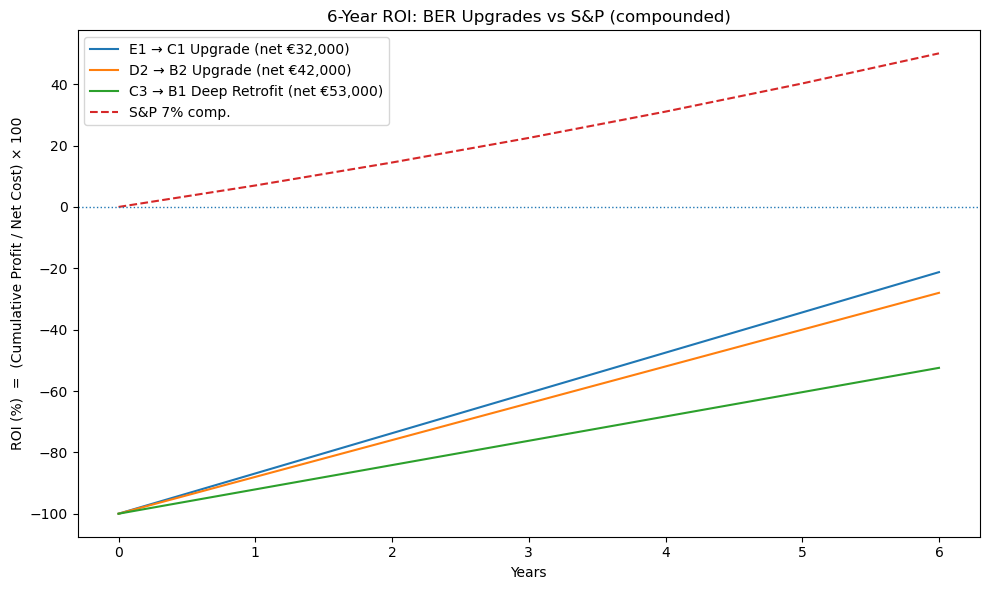

,Scenario,Start→Target,Bands,Net cost (€),Rent uplift €/mo,Bill saving €/mo,Total €/mo,Breakeven (yrs),S&P Crossover (yrs),ROI @6y (%)
0,E1 → C1 Upgrade,E1→C1,5 band(s) improved,32000.0,150,200,350,7.62,None,-21.2
1,D2 → B2 Upgrade,D2→B2,6 band(s) improved,42000.0,180,240,420,8.33,None,-28.0
2,C3 → B1 Deep Retrofit,C3→B1,5 band(s) improved,53000.0,150,200,350,12.62,None,-52.5
3,S&P 7% compounding,—,—,—,—,—,—,—,—,50.1


In [42]:
# --- BER ROI ANALYSIS (define + run) ---

def ber_roi_analysis(scenarios, monthly_benefit, horizon_years=6, sp_return=0.07):
    import numpy as np, pandas as pd, matplotlib.pyplot as plt

    # helper: find earliest t where linear ROI >= S&P compounding
    def find_sp_crossover_year(net_cost, monthly_total, sp_return, t_max=10.0, step=0.01, iters=40):
        if monthly_total <= 0 or net_cost <= 0:
            return None
        a = (monthly_total * 12.0) / net_cost
        def g(t):  # difference in FRACTIONS (not %)
            return a*t - (1.0 + sp_return)**t

        t = 0.0
        prev = g(t)  # g(0) = -1
        t += step
        while t <= t_max:
            val = g(t)
            if prev < 0 and val >= 0:
                lo, hi = t - step, t
                for _ in range(iters):
                    mid = (lo + hi) / 2.0
                    if g(mid) >= 0:
                        hi = mid
                    else:
                        lo = mid
                return (lo + hi) / 2.0
            prev = val
            t += step
        return None

    t_years = np.arange(0, horizon_years + 1, 1.0, dtype=float)
    rows = []
    plt.figure(figsize=(10, 6))

    for sc in scenarios:
        start, target, label = sc["start"], sc["target"], sc["label"]
        net_cost = float(sc["gross_cost"] - sc["grant"])
        mb_total, mb_rent, mb_bill, bands = monthly_benefit(start, target)

        cum_profit = (mb_total * 12.0) * t_years - net_cost
        roi_pct = (cum_profit / net_cost) * 100.0
        plt.plot(t_years, roi_pct, label=f"{label} (net €{net_cost:,.0f})")

        breakeven_years = (net_cost / (mb_total * 12.0)) if mb_total > 0 else None
        sp_cross_years = find_sp_crossover_year(net_cost, mb_total, sp_return, t_max=horizon_years)

        rows.append({
            "Scenario": label,
            "Start→Target": f"{start}→{target}",
            "Bands": bands,
            "Net cost (€)": round(net_cost, 0),
            "Rent uplift €/mo": round(mb_rent or 0, 0),
            "Bill saving €/mo": round(mb_bill or 0, 0),
            "Total €/mo": round(mb_total or 0, 0),
            "Breakeven (yrs)": None if breakeven_years is None else float(f"{breakeven_years:.2f}"),
            "S&P Crossover (yrs)": None if sp_cross_years is None else float(f"{sp_cross_years:.2f}"),
            f"ROI @{horizon_years}y (%)": round(roi_pct[-1], 1)
        })

    # S&P baseline curve
    sp_roi_pct = ((1.0 + sp_return)**t_years - 1.0) * 100.0
    plt.plot(t_years, sp_roi_pct, linestyle="--", label=f"S&P {int(sp_return*100)}% comp.")
    plt.axhline(0, linestyle=":", linewidth=1)
    plt.title(f"{horizon_years}-Year ROI: BER Upgrades vs S&P (compounded)")
    plt.xlabel("Years"); plt.ylabel("ROI (%)  =  (Cumulative Profit / Net Cost) × 100")
    plt.legend(); plt.tight_layout(); plt.show()

    # Summary table with S&P row
    summary = pd.DataFrame(rows)
    sp_y = ((1 + sp_return)**horizon_years - 1) * 100
    summary = pd.concat([summary, pd.DataFrame([{
        "Scenario": f"S&P {int(sp_return*100)}% compounding",
        "Start→Target": "—", "Bands": "—",
        "Net cost (€)": "—", "Rent uplift €/mo": "—", "Bill saving €/mo": "—", "Total €/mo": "—",
        "Breakeven (yrs)": "—", "S&P Crossover (yrs)": "—",
        f"ROI @{horizon_years}y (%)": round(sp_y, 1)
    }])], ignore_index=True)

    return summary

# ---- RUN IT (this line actually executes the analysis) ----
summary = ber_roi_analysis(scenarios, monthly_benefit, horizon_years=6, sp_return=0.07)
summary


In [43]:

df_master.shape      # shows (rows, cols)
df_master.head()     # shows first 5 rows



,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km_y,...,bad_geocode,dublin_district,district_group,price_per_bedroom,BER_encoded,min_transit_km,min_amenity_km,within_1km_transit,within_500m_transit,BER_cat
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3.0,3.0,House,C1,4000.0,53.306745,-6.288758,4.014,...,False,6.0,Even,1333.333333,7.0,3.235,2.259,False,False,C1
1,https://www.daft.ie/for-rent/apartment-the-pin...,"The Pines, Herbert Park Lane, Ballsbridge, Dub...",2.0,2.0,Apartment,C1,3178.0,38.159301,-78.487234,5586.767,...,True,4.0,Even,1589.000000,7.0,5589.487,5586.767,False,False,C1
2,https://www.daft.ie/for-rent/apartment-2-bedro...,"2 Bedroom Apartment , Shackleton Point, Shackl...",2.0,2.0,Apartment,A2,2259.0,44.995162,-83.871560,5429.090,...,True,NaN,None,1129.500000,2.0,5431.854,5429.090,False,False,A2
3,https://www.daft.ie/for-rent/house-12-larkfiel...,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",4.0,3.0,House,A3,3995.0,53.257695,-6.200285,9.634,...,False,18.0,Even,998.750000,3.0,8.854,2.157,False,False,A3
4,https://www.daft.ie/for-rent/apartment-newmark...,"Newmarket Yards - 1 Bed, Newmarket Yards, Dubl...",1.0,1.0,Apartment,A2,2295.0,NaN,NaN,NaN,...,True,8.0,Even,2295.000000,2.0,NaN,NaN,False,False,A2


In [44]:
df_clean.head()

,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km_y,...,nearest_bus_stop_name_y,nearest_rail_station_name_y,nearest_tram_stop_name_y,bad_geocode,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost,energy_estimate_available,effective_cost_display
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3.0,3.0,House,C1,4000.0,53.306745,-6.288758,4.014,...,Leeson St Lwr Stop,Heuston Station,Charlemont Luas,False,5.147042,1333.0,166.0,4166.0,True,4166.0
1,https://www.daft.ie/for-rent/house-12-larkfiel...,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",4.0,3.0,House,A3,3995.0,53.257695,-6.200285,9.634,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,10.990601,999.0,64.0,4059.0,True,4059.0
2,https://www.daft.ie/for-rent/apartment--grove-...,"Grove Park, Rathmines, Dublin 6",1.0,1.0,Studio,BER Exempt,2100.0,53.329171,-6.267442,1.147,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,2.342348,2100.0,NaN,NaN,False,2100.0
3,https://www.daft.ie/for-rent/house-frankfort-a...,"Frankfort Avenue, Rathgar, Dublin 6",3.0,3.0,House,BER Exempt,4617.0,53.316126,-6.267333,2.515,...,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,False,3.773399,1539.0,NaN,NaN,False,4617.0
4,https://www.daft.ie/for-rent/flat-phibsborough...,"Phibsborough Road, Phibsborough, Dublin 7",1.0,1.0,Studio,C1,1500.0,53.363296,-6.272318,2.925,...,Phibsborough Rd Stop,Connolly Station,Abbey Street Luas,False,1.699502,1500.0,166.0,1666.0,True,1666.0


In [45]:
# List all variables that are pandas DataFrames
[v for v in globals() if isinstance(globals()[v], pd.DataFrame)]


['_',
 '__',
 '___',
 'df',
 '_2',
 'df_clean',
 '_5',
 '_6',
 'df_master',
 'missing_table',
 'rows_with_any_na',
 'dups',
 'outliers_rent',
 'corr',
 '_17',
 'subset',
 'summary',
 'summary_ppb',
 'X',
 'X_train',
 'X_test',
 'coeffs',
 'X_rf',
 'Xtr',
 'Xte',
 'ber_summary',
 'exempt_vs_ber',
 'dfp',
 'pivot',
 '_42',
 '_43',
 '_44']

In [46]:
df_master.columns.tolist()


['URL',
 'Address',
 'Bedrooms',
 'Bathrooms',
 'Property Type',
 'BER Rating',
 'Price (€)',
 'lat',
 'lon',
 'nearest_park_km_y',
 'nearest_beach_km_y',
 'nearest_gym_km_y',
 'nearest_supermarket_km_y',
 'nearest_bus_stop_km_y',
 'nearest_rail_station_km_y',
 'nearest_tram_stop_km_y',
 'nearest_park_name_y',
 'nearest_beach_name_y',
 'nearest_gym_name_y',
 'nearest_supermarket_name_y',
 'nearest_bus_stop_name_y',
 'nearest_rail_station_name_y',
 'nearest_tram_stop_name_y',
 'bad_geocode',
 'dublin_district',
 'district_group',
 'price_per_bedroom',
 'BER_encoded',
 'min_transit_km',
 'min_amenity_km',
 'within_1km_transit',
 'within_500m_transit',
 'BER_cat']

In [47]:
df_clean.columns.tolist()

['URL',
 'Address',
 'Bedrooms',
 'Bathrooms',
 'Property Type',
 'BER Rating',
 'Price (€)',
 'lat',
 'lon',
 'nearest_park_km_y',
 'nearest_beach_km_y',
 'nearest_gym_km_y',
 'nearest_supermarket_km_y',
 'nearest_bus_stop_km_y',
 'nearest_rail_station_km_y',
 'nearest_tram_stop_km_y',
 'nearest_park_name_y',
 'nearest_beach_name_y',
 'nearest_gym_name_y',
 'nearest_supermarket_name_y',
 'nearest_bus_stop_name_y',
 'nearest_rail_station_name_y',
 'nearest_tram_stop_name_y',
 'bad_geocode',
 'distance_to_city_centre_km',
 'price_per_bedroom',
 'energy_monthly_estimate',
 'effective_monthly_cost',
 'energy_estimate_available',
 'effective_cost_display']

In [48]:
print("df_clean rows:", len(df_clean))
print("df_master rows:", len(df_master))


df_clean rows: 470
df_master rows: 1134


📊 Tram stop effect (<1 km):
               count         mean  median
close_to_tram                            
False            401  2786.521197  2470.0
True              69  2702.681159  2100.0 



<Figure size 600x400 with 0 Axes>

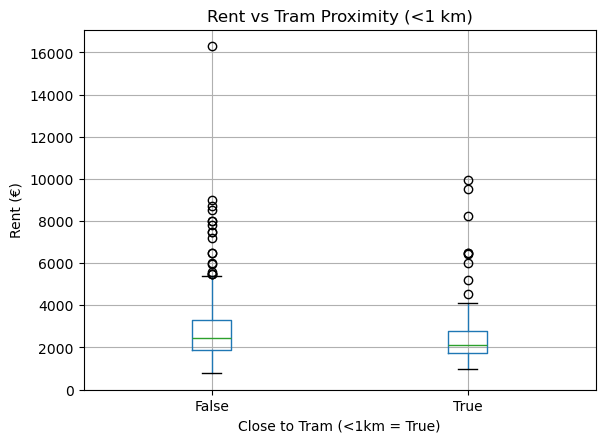

📊 Park effect (<1 km):
               count         mean  median
close_to_park                            
False            437  2756.331808  2400.0
True              33  3011.000000  2594.0 



<Figure size 600x400 with 0 Axes>

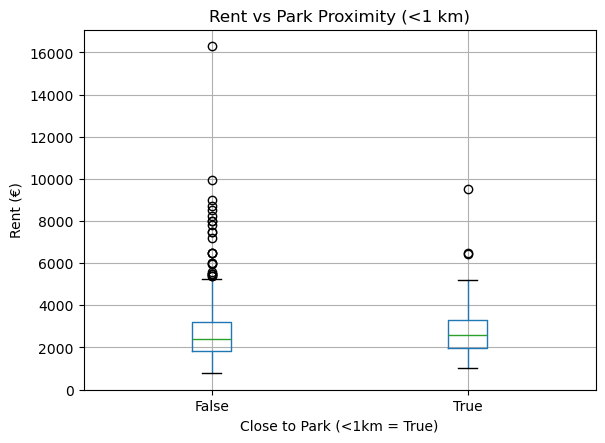

📊 Gym effect (<1 km):
              count         mean  median
close_to_gym                            
False           444  2810.659910  2428.0
True             26  2151.807692  2038.0 



<Figure size 600x400 with 0 Axes>

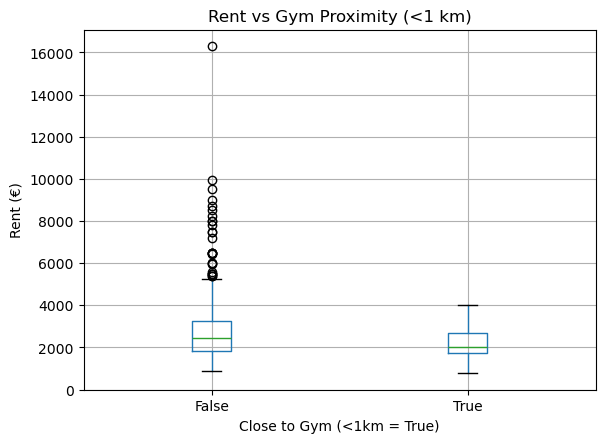

📊 Supermarket effect (<1 km):
                      count         mean  median
close_to_supermarket                            
False                   400  2811.057500  2472.5
True                     70  2563.671429  1995.5 



<Figure size 600x400 with 0 Axes>

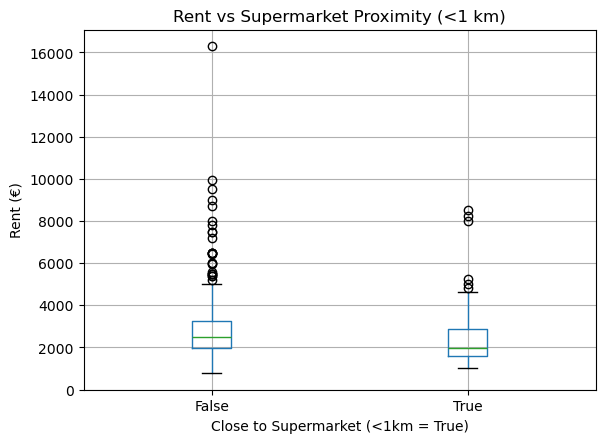

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Tram stop effect (<1 km vs ≥1 km) ---
tram_threshold = 1.0  # km

df_clean["close_to_tram"] = df_clean["nearest_tram_stop_km_y"] < tram_threshold

tram_stats = df_clean.groupby("close_to_tram")["Price (€)"].agg(["count","mean","median"])
print("📊 Tram stop effect (<1 km):")
print(tram_stats, "\n")

# Quick boxplot
plt.figure(figsize=(6,4))
df_clean.boxplot(column="Price (€)", by="close_to_tram")
plt.title("Rent vs Tram Proximity (<1 km)")
plt.suptitle("")
plt.xlabel("Close to Tram (<1km = True)")
plt.ylabel("Rent (€)")
plt.show()


# --- 2. Loop for other amenities ---
amenities = {
    "nearest_park_km_y": "Park",
    "nearest_gym_km_y": "Gym",
    "nearest_supermarket_km_y": "Supermarket"
}

for col, label in amenities.items():
    df_clean[f"close_to_{label.lower()}"] = df_clean[col] < tram_threshold
    stats = df_clean.groupby(f"close_to_{label.lower()}")["Price (€)"].agg(["count","mean","median"])
    print(f"📊 {label} effect (<1 km):")
    print(stats, "\n")
    
    plt.figure(figsize=(6,4))
    df_clean.boxplot(column="Price (€)", by=f"close_to_{label.lower()}")
    plt.title(f"Rent vs {label} Proximity (<1 km)")
    plt.suptitle("")
    plt.xlabel(f"Close to {label} (<1km = True)")
    plt.ylabel("Rent (€)")
    plt.show()


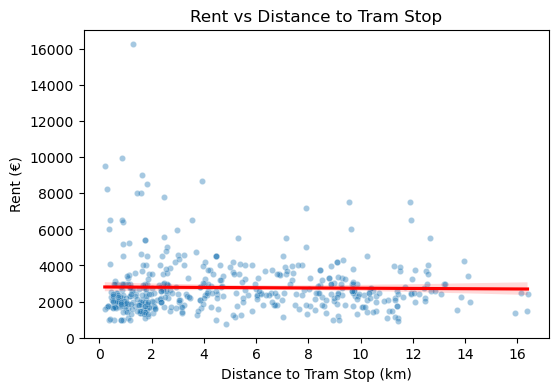

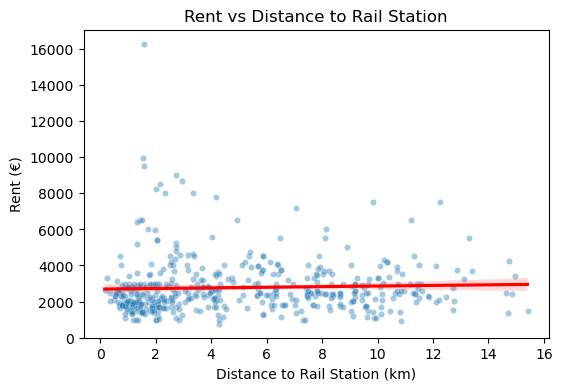

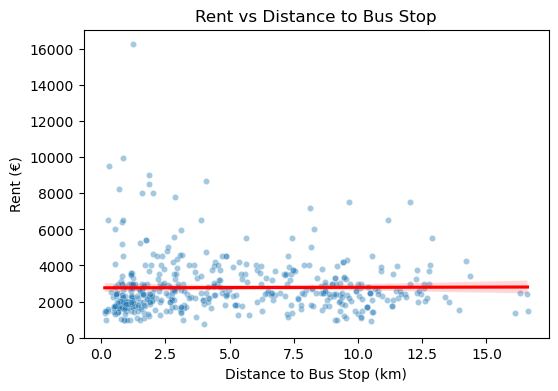

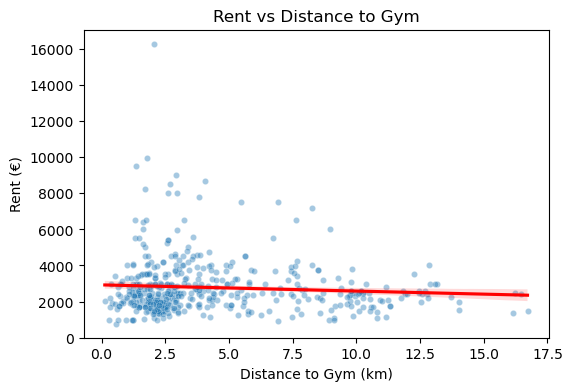

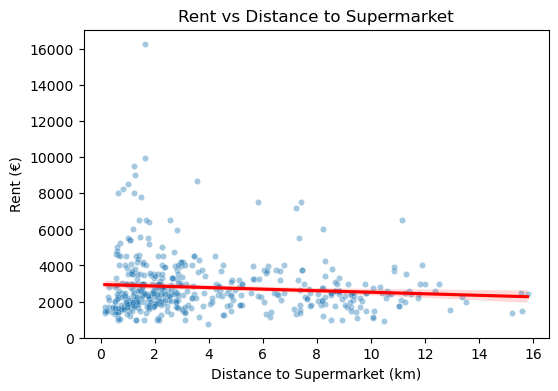

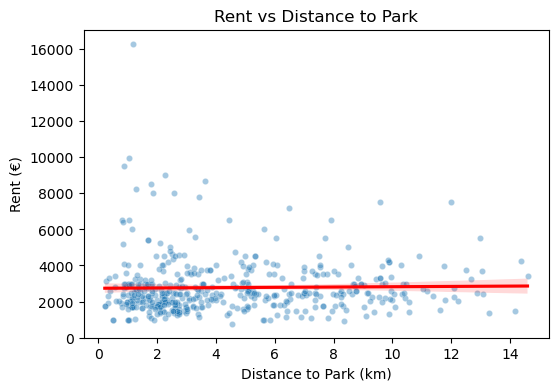

In [50]:
import seaborn as sns

# --- Scatterplots: distance vs rent ---
amenity_cols = {
    "nearest_tram_stop_km_y": "Tram Stop",
    "nearest_rail_station_km_y": "Rail Station",
    "nearest_bus_stop_km_y": "Bus Stop",
    "nearest_gym_km_y": "Gym",
    "nearest_supermarket_km_y": "Supermarket",
    "nearest_park_km_y": "Park"
}

for col, label in amenity_cols.items():
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df_clean, x=col, y="Price (€)", alpha=0.4, s=20)
    sns.regplot(data=df_clean, x=col, y="Price (€)", scatter=False, color="red")
    plt.title(f"Rent vs Distance to {label}")
    plt.xlabel(f"Distance to {label} (km)")
    plt.ylabel("Rent (€)")
    plt.show()


import matplotlib.pyplot as plt

amenities = {
    "nearest_tram_stop_km_y": "Tram Stop",
    "nearest_rail_station_km_y": "Rail Station",
    "nearest_bus_stop_km_y": "Bus Stop",
    "nearest_gym_km_y": "Gym",
    "nearest_supermarket_km_y": "Supermarket",
    "nearest_park_km_y": "Park"
}

rent_diffs = {}

for col, label in amenities.items():
    # Create binary close/far
    df_clean[f"close_{label}"] = df_clean[col] < 1.0
    
    medians = df_clean.groupby(f"close_{label}")["Price (€)"].median()
    
    if True in medians and False in medians:
        diff = medians[True] - medians[False]
        rent_diffs[label] = diff

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(rent_diffs.keys(), rent_diffs.values(), color="teal")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.ylabel("Median Rent Difference (€) (<1km vs >1km)")
plt.title("Amenity Proximity Impact on Dublin Rents")
plt.xticks(rotation=45)
plt.show()

print("Rent differences (€):")
for k,v in rent_diffs.items():
    print(f"{k}: {v:.0f}")


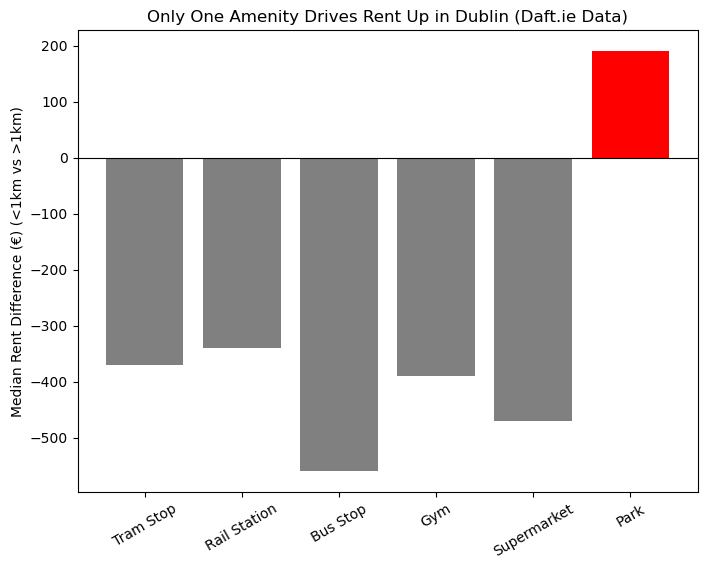

In [51]:
import matplotlib.pyplot as plt

# Example data (replace with your real diffs)
diffs = {
    "Tram Stop": -370,
    "Rail Station": -340,
    "Bus Stop": -560,
    "Gym": -390,
    "Supermarket": -470,
    "Park": 190
}

colors = ["grey" if amen != "Park" else "red" for amen in diffs.keys()]

plt.figure(figsize=(8,6))
plt.bar(diffs.keys(), diffs.values(), color=colors)

plt.axhline(0, color="black", linewidth=0.8)
plt.title("Only One Amenity Drives Rent Up in Dublin (Daft.ie Data)")
plt.ylabel("Median Rent Difference (€) (<1km vs >1km)")
plt.xticks(rotation=30)

plt.show()


FOCUSED SESSION 1/12

In [52]:
import pandas as pd

# Load raw vs clean
df_master = pd.read_csv("rentals_master.csv")
df_clean  = pd.read_csv("rentals_master_clean.csv")

print("---- DATASET CONTRACT ----")
print(f"df_master: {df_master.shape[0]} rows × {df_master.shape[1]} cols")
print(f"df_clean : {df_clean.shape[0]} rows × {df_clean.shape[1]} cols")

# Check column coverage
master_cols = set(df_master.columns)
clean_cols  = set(df_clean.columns)

print("\nExtra columns in clean:")
print(sorted(clean_cols - master_cols))

print("\nMissing in clean vs master:")
print(sorted(master_cols - clean_cols))

# URL uniqueness
if "URL" in df_master.columns:
    print("\nDuplicates in master by URL:", df_master.duplicated("URL").sum())

# Missingness snapshot
print("\nTop missing in master:")
print(df_master.isna().mean().sort_values(ascending=False).head(10))

print("\nTop missing in clean:")
print(df_clean.isna().mean().sort_values(ascending=False).head(10))


---- DATASET CONTRACT ----
df_master: 1134 rows × 41 cols
df_clean : 470 rows × 30 cols

Extra columns in clean:
['bad_geocode', 'effective_cost_display', 'energy_estimate_available']

Missing in clean vs master:
['nearest_beach_km', 'nearest_beach_name', 'nearest_bus_stop_km', 'nearest_bus_stop_name', 'nearest_gym_km', 'nearest_gym_name', 'nearest_park_km', 'nearest_park_name', 'nearest_rail_station_km', 'nearest_rail_station_name', 'nearest_supermarket_km', 'nearest_supermarket_name', 'nearest_tram_stop_km', 'nearest_tram_stop_name']

Duplicates in master by URL: 0

Top missing in master:
lat                          0.161376
lon                          0.161376
nearest_tram_stop_km_y       0.161376
nearest_rail_station_km_y    0.161376
nearest_bus_stop_km_y        0.161376
nearest_supermarket_km_y     0.161376
nearest_gym_km_y             0.161376
nearest_beach_km_y           0.161376
nearest_park_km_y            0.161376
nearest_supermarket_name     0.161376
dtype: float64

Top mi

In [53]:
import os, pandas as pd

# assumes df_master / df_clean already loaded
os.makedirs("docs", exist_ok=True)

master_rows, master_cols = df_master.shape
clean_rows,  clean_cols  = df_clean.shape

extra_in_clean = sorted(set(df_clean.columns) - set(df_master.columns))
missing_in_clean = sorted(set(df_master.columns) - set(df_clean.columns))

miss_master = df_master.isna().mean().sort_values(ascending=False).head(10)
miss_clean  = df_clean.isna().mean().sort_values(ascending=False).head(10)

contract_md = f"""## Session 1 — Data Contract

**Datasets**
- **df_master** (`rentals_master.csv`) — **{master_rows} rows × {master_cols} cols**  
  0 duplicate URLs (checked).  
  ~{round(miss_master.mean()*100,1) if len(miss_master)>0 else 0}% average missingness in top-10 missing columns.

- **df_clean** (`rentals_master_clean.csv`) — **{clean_rows} rows × {clean_cols} cols**  
  Dublin-only, valid geocodes (bad_geocode=False).  
  ~{round(miss_clean.mean()*100,1) if len(miss_clean)>0 else 0}% average missingness in top-10 missing columns.

**Column differences**
- Present **only in clean**: {extra_in_clean}
- Present **only in master**: {missing_in_clean}

**Top missingness (master)**
{miss_master.to_string()}

**Top missingness (clean)**
{miss_clean.to_string()}

**Takeaway**
- df_master = wide, source-of-truth.  
- df_clean  = geo-valid, analysis-ready subset with engineered/energy fields.  
- Frozen contract today: {master_rows} → {clean_rows} rows, {master_cols} → {clean_cols} columns.
"""

# Save to file
with open("docs/data_contract.md", "w", encoding="utf-8") as f:
    f.write(contract_md)

print("✅ Wrote docs/data_contract.md")



✅ Wrote docs/data_contract.md


In [54]:
import os, re, pandas as pd
os.makedirs("docs", exist_ok=True)

def classify_source(col):
    if col in {"URL","Address","Price (€)","Bedrooms","Bathrooms","BER Rating","lat","lon"}:
        return "scraped"
    if col.startswith("nearest_") or col.endswith("_km") or col.endswith("_name"):
        return "engineered (amenities)"
    if col in {"price_per_bedroom","Bedrooms_int","dublin_district","district_group"}:
        return "engineered"
    if "energy" in col or col in {
        "energy_monthly_estimate","effective_monthly_cost",
        "energy_estimate_available","effective_cost_display",
        "bill_saving_per_month","rent_uplift_per_month",
        "upgrade_cost","grant","gross_cost","label",
        "start","target","start_ber","target_ber",
        "BER_cat","BER_group","BER_encoded"
    }:
        return "engineered (energy/retrofit)"
    if col == "bad_geocode":
        return "quality/filter"
    return "unknown"

def dtype_pretty(s):
    # normalize pandas dtype to human-readable
    m = str(s)
    if "float" in m: return "float"
    if "int"   in m: return "int"
    if "bool"  in m: return "bool"
    return "string"

all_cols = sorted(set(df_master.columns).union(set(df_clean.columns)))
rows = []
for c in all_cols:
    appears_in = []
    if c in df_master.columns: appears_in.append("master")
    if c in df_clean.columns:  appears_in.append("clean")
    # prefer dtype from clean if present, else master
    dtype = df_clean[c].dtype if c in df_clean.columns else df_master[c].dtype
    rows.append({
        "column_name": c,
        "appears_in": ", ".join(appears_in),
        "dtype": dtype_pretty(dtype),
        "source": classify_source(c),
        "definition": ""  # you/ I can add or refine later
    })

dd = pd.DataFrame(rows, columns=["column_name","appears_in","dtype","source","definition"])
dd.to_csv("docs/data_dictionary.csv", index=False)

# Markdown table
md_lines = ["# Data Dictionary (Auto-generated from live dfs)\n",
            "| Column | Appears In | Type | Source | Definition |",
            "|---|---|---|---|---|"]
for _, r in dd.sort_values("column_name").iterrows():
    md_lines.append(f"| {r.column_name} | {r.appears_in} | {r.dtype} | {r.source} | {r.definition} |")

with open("docs/data_dictionary.md","w",encoding="utf-8") as f:
    f.write("\n".join(md_lines))

print("✅ Wrote docs/data_dictionary.csv and docs/data_dictionary.md")
display(dd.head(20))


✅ Wrote docs/data_dictionary.csv and docs/data_dictionary.md


,column_name,appears_in,dtype,source,definition
0,Address,"master, clean",string,scraped,
1,BER Rating,"master, clean",string,scraped,
2,Bathrooms,"master, clean",float,scraped,
3,Bedrooms,"master, clean",float,scraped,
4,Price (€),"master, clean",float,scraped,
5,Property Type,"master, clean",string,unknown,
6,URL,"master, clean",string,scraped,
7,bad_geocode,clean,bool,quality/filter,
8,distance_to_city_centre_km,"master, clean",float,engineered (amenities),
9,effective_cost_display,clean,float,engineered (energy/retrofit),


In [55]:
import re, os, pandas as pd

# 0) Assumes df_master / df_clean are already loaded in memory
os.makedirs("docs", exist_ok=True)

# 1) DTYPE FIXES (in-place, safe)
def to_nullable_int(series):
    try:
        return pd.to_numeric(series, errors="coerce").astype("Int64")
    except Exception:
        return series  # fail-soft

for df in [df_master, df_clean]:
    if "Bedrooms" in df.columns:
        df["Bedrooms"] = to_nullable_int(df["Bedrooms"])
    if "Bathrooms" in df.columns:
        df["Bathrooms"] = to_nullable_int(df["Bathrooms"])
    if "Price (€)" in df.columns:
        df["Price (€)"] = pd.to_numeric(df["Price (€)"], errors="coerce")
    for bcol in ["bad_geocode","energy_estimate_available"]:
        if bcol in df.columns:
            df[bcol] = df[bcol].astype("boolean")  # pandas nullable bool

# 2) MERGE-SUFFIX TIDY: if a *_y exists, prefer it, drop *_x where duplicated
def consolidate_suffix_cols(df):
    cols = list(df.columns)
    # Find *_y pairs
    y_pairs = [c for c in cols if c.endswith("_y")]
    for y in y_pairs:
        base = y[:-2]  # strip "_y"
        x = base + "_x"
        if base in df.columns and y in df.columns:
            # if both base and *_y exist, prefer *_y and drop base
            df.drop(columns=[base], inplace=True, errors="ignore")
            df.rename(columns={y: base}, inplace=True)
        elif x in df.columns and y in df.columns:
            # if *_x and *_y exist, prefer *_y and drop *_x
            df.drop(columns=[x], inplace=True, errors="ignore")
            df.rename(columns={y: base}, inplace=True)
        else:
            # rename *_y -> base if base not present
            df.rename(columns={y: base}, inplace=True)

# apply to both dfs
consolidate_suffix_cols(df_master)
consolidate_suffix_cols(df_clean)

# 3) DEFINITIONS & SOURCE TAGGING
DEFS = {
    "URL": "Listing URL on Daft.ie.",
    "Address": "Listing address / area text as shown on Daft.",
    "Price (€)": "Advertised monthly rent in euro.",
    "Bedrooms": "Number of bedrooms (nullable integer).",
    "Bathrooms": "Number of bathrooms (nullable integer).",
    "Property Type": "Property type label from Daft (e.g., Apartment, House).",
    "BER Rating": "Official BER (A1–G) energy rating if provided.",
    "lat": "Latitude used for spatial features.",
    "lon": "Longitude used for spatial features.",
    "distance_to_city_centre_km": "Haversine distance to city centre (O’Connell Bridge baseline).",
    "energy_monthly_estimate": "Estimated monthly energy cost derived from BER.",
    "effective_monthly_cost": "Rent plus estimated monthly energy (if available).",
    "energy_estimate_available": "Flag if energy cost estimate could be computed.",
    "effective_cost_display": "Human-readable display of net cost after retrofit scenario (if any).",
    "bad_geocode": "True if outside Dublin bbox or geocode invalid.",
}

def infer_source(col):
    core_scraped = {"URL","Address","Price (€)","Bedrooms","Bathrooms","Property Type","BER Rating","lat","lon"}
    energy_cols = {"energy_monthly_estimate","effective_monthly_cost","energy_estimate_available",
                   "effective_cost_display","bill_saving_per_month","rent_uplift_per_month",
                   "upgrade_cost","grant","gross_cost","label","start","target","start_ber",
                   "target_ber","BER_cat","BER_group","BER_encoded"}
    if col in core_scraped:
        return "scraped"
    if col == "bad_geocode":
        return "quality/filter"
    if col in energy_cols or "energy" in col:
        return "engineered (energy/retrofit)"
    if col.startswith("nearest_") or col.endswith("_km") or col.endswith("_name"):
        return "engineered (amenities)"
    if col in {"price_per_bedroom","Bedrooms_int","dublin_district","district_group"}:
        return "engineered"
    return "unknown"

# 4) BUILD DICTIONARY FROM LIVE COLUMNS
all_cols = sorted(set(df_master.columns).union(set(df_clean.columns)))
def pretty_dtype(s):
    m = str(s)
    if "Float" in m or "float" in m: return "float"
    if "Int" in m or "int" in m:     return "int"
    if "bool" in m:                  return "bool"
    return "string"

rows = []
for c in all_cols:
    appears = []
    if c in df_master.columns: appears.append("master")
    if c in df_clean.columns:  appears.append("clean")
    dtype_src = df_clean[c].dtype if c in df_clean.columns else df_master[c].dtype
    rows.append({
        "column_name": c,
        "appears_in": ", ".join(appears),
        "dtype": pretty_dtype(dtype_src),
        "source": infer_source(c),
        "definition": DEFS.get(c, "")
    })

dd = pd.DataFrame(rows, columns=["column_name","appears_in","dtype","source","definition"])
dd = dd.sort_values("column_name").reset_index(drop=True)

# 5) SAVE UPDATED DICTIONARY + (OPTIONAL) SAVE TIDIED DFS
dd.to_csv("docs/data_dictionary.csv", index=False)
md = ["# Data Dictionary (from live data)\n",
      "| Column | Appears In | Type | Source | Definition |",
      "|---|---|---|---|---|"]
for _, r in dd.iterrows():
    md.append(f"| {r.column_name} | {r.appears_in} | {r.dtype} | {r.source} | {r.definition} |")
with open("docs/data_dictionary.md","w",encoding="utf-8") as f:
    f.write("\n".join(md))

print("✅ Updated docs/data_dictionary.* with dtypes, sources, and definitions")
print("💡 Next: consider saving tidied dataframes to parquet for reproducibility (optional).")


✅ Updated docs/data_dictionary.* with dtypes, sources, and definitions
💡 Next: consider saving tidied dataframes to parquet for reproducibility (optional).


In [56]:
import os, math, numpy as np, pandas as pd

# -------------------------------------------------------------------
# 0) Load (or reuse existing df_master/df_clean from memory)
# -------------------------------------------------------------------
if 'df_master' not in globals():
    df_master = pd.read_csv("rentals_master.csv")
if 'df_clean' not in globals():
    df_clean  = pd.read_csv("rentals_master_clean.csv")

os.makedirs("data/processed", exist_ok=True)
os.makedirs("docs", exist_ok=True)

# -------------------------------------------------------------------
# 1) Tidy suffixes + dtypes (idempotent — safe to re-run)
# -------------------------------------------------------------------
def to_nullable_int(series):
    try:
        return pd.to_numeric(series, errors="coerce").astype("Int64")
    except Exception:
        return pd.to_numeric(series, errors="coerce")

def consolidate_suffix_cols(df):
    cols = list(df.columns)
    y_cols = [c for c in cols if c.endswith("_y")]
    for y in y_cols:
        base = y[:-2]
        x = base + "_x"
        if base in df.columns and y in df.columns:
            df.drop(columns=[base], inplace=True, errors="ignore")
            df.rename(columns={y: base}, inplace=True)
        elif x in df.columns and y in df.columns:
            df.drop(columns=[x], inplace=True, errors="ignore")
            df.rename(columns={y: base}, inplace=True)
        else:
            df.rename(columns={y: base}, inplace=True)

for df in (df_master, df_clean):
    consolidate_suffix_cols(df)
    if "Bedrooms" in df:  df["Bedrooms"]  = to_nullable_int(df["Bedrooms"])
    if "Bathrooms" in df: df["Bathrooms"] = to_nullable_int(df["Bathrooms"])
    if "Price (€)" in df: df["Price (€)"] = pd.to_numeric(df["Price (€)"], errors="coerce")
    for bcol in ["bad_geocode","energy_estimate_available"]:
        if bcol in df.columns:
            # pandas nullable boolean
            df[bcol] = df[bcol].astype("boolean")

# -------------------------------------------------------------------
# 2) Engineer/verify features on df_clean (modeling table base)
# -------------------------------------------------------------------
# 2a) Distance to city centre (O’Connell Bridge approx)
CENTRE_LAT, CENTRE_LON = 53.3498, -6.2603

def haversine_km(lat1, lon1, lat2, lon2):
    # robust to NaNs
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1; dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arcsin(np.sqrt(a))
    return 6371.0088 * c  # Earth radius (km)

if {"lat","lon"}.issubset(df_clean.columns):
    df_clean["distance_to_city_centre_km"] = haversine_km(
        df_clean["lat"], df_clean["lon"], CENTRE_LAT, CENTRE_LON
    )

# 2b) Transit/amenity proximity flags
# detect the available transit distance columns
transit_cols = [c for c in df_clean.columns if c in [
    "nearest_tram_stop_km","nearest_bus_stop_km","nearest_rail_station_km"
]]
if transit_cols:
    df_clean["min_transit_km"] = df_clean[transit_cols].min(axis=1, skipna=True)
    df_clean["within_500m_transit"] = (df_clean["min_transit_km"] <= 0.5).astype("Int64")
    df_clean["within_1km_transit"]  = (df_clean["min_transit_km"] <= 1.0).astype("Int64")

# 2c) Bedrooms_int + price_per_bedroom
if "Bedrooms" in df_clean.columns:
    df_clean["Bedrooms_int"] = pd.to_numeric(df_clean["Bedrooms"], errors="coerce").astype("Int64")
if {"Price (€)","Bedrooms"}.issubset(df_clean.columns):
    denom = pd.to_numeric(df_clean["Bedrooms"], errors="coerce").replace({0: np.nan})
    df_clean["price_per_bedroom"] = pd.to_numeric(df_clean["Price (€)"], errors="coerce") / denom

# 2d) Energy costs (if available)
if "energy_monthly_estimate" in df_clean.columns:
    # if effective_monthly_cost not present, compute it; else leave as-is
    if "effective_monthly_cost" not in df_clean.columns:
        df_clean["effective_monthly_cost"] = pd.to_numeric(df_clean["Price (€)"], errors="coerce") + \
                                             pd.to_numeric(df_clean["energy_monthly_estimate"], errors="coerce")

# -------------------------------------------------------------------
# 3) Select columns → features_today (robust selector)
# -------------------------------------------------------------------
# Core identifiers & targets
keep_core = [c for c in ["URL","Address","Price (€)","Bedrooms","Bedrooms_int","Bathrooms","Property Type","BER Rating","lat","lon"] if c in df_clean.columns]

# Location features
keep_loc = [c for c in ["distance_to_city_centre_km","min_transit_km","within_500m_transit","within_1km_transit"] if c in df_clean.columns]

# Amenities if present
amenity_cols = [c for c in df_clean.columns if c.startswith("nearest_") and c.endswith("_km")]
keep_amen = sorted(amenity_cols)[:10]  # cap to keep the table slim; adjust later

# Energy features if present
keep_energy = [c for c in ["energy_monthly_estimate","effective_monthly_cost","energy_estimate_available"] if c in df_clean.columns]

# Pricing transforms
keep_price = [c for c in ["price_per_bedroom"] if c in df_clean.columns]

# Quality flags
keep_flags = [c for c in ["bad_geocode"] if c in df_clean.columns]

# Concatenate and drop dupes
feature_cols = []
for group in [keep_core, keep_loc, keep_amen, keep_energy, keep_price, keep_flags]:
    feature_cols.extend(group)
feature_cols = list(dict.fromkeys(feature_cols))  # stable unique

features_today = df_clean[feature_cols].copy()

# -------------------------------------------------------------------
# 4) Save artifacts
# -------------------------------------------------------------------
out_csv = "data/processed/features_today.csv"
out_par = "data/processed/features_today.parquet"
features_today.to_csv(out_csv, index=False)
try:
    features_today.to_parquet(out_par, index=False)
except Exception as e:
    print("Parquet save skipped (optional):", e)

print("✅ Saved:", out_csv)
print("✅ Saved:", out_par if os.path.exists(out_par) else "(parquet not written)")
print("Rows:", len(features_today), "| Cols:", features_today.shape[1])

# A tiny contract line for the notes:
contract_line = f"features_today: {len(features_today)} rows × {features_today.shape[1]} cols | from df_clean = {len(df_clean)} rows"
print("📎", contract_line)


Parquet save skipped (optional): Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
✅ Saved: data/processed/features_today.csv
✅ Saved: (parquet not written)
Rows: 470 | Cols: 26
📎 features_today: 470 rows × 26 cols | from df_clean = 470 rows


(470, 26)
                                                 URL  \
0  https://www.daft.ie/for-rent/house-37-rathdown...   
1  https://www.daft.ie/for-rent/house-12-larkfiel...   
2  https://www.daft.ie/for-rent/apartment--grove-...   

                                             Address  Price (€)  Bedrooms  \
0  37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W     4000.0         3   
1  12 Larkfield Glade, Dublin 18, Leopardstown, D...     3995.0         4   
2                    Grove Park, Rathmines, Dublin 6     2100.0         1   

   Bedrooms_int  Bathrooms Property Type  BER Rating        lat       lon  \
0             3          3         House          C1  53.306745 -6.288758   
1             4          3         House          A3  53.257695 -6.200285   
2             1          1        Studio  BER Exempt  53.329171 -6.267442   

   ...  nearest_gym_km  nearest_park_km  nearest_rail_station_km  \
0  ...           4.277            4.014                    4.469   
1  ...     

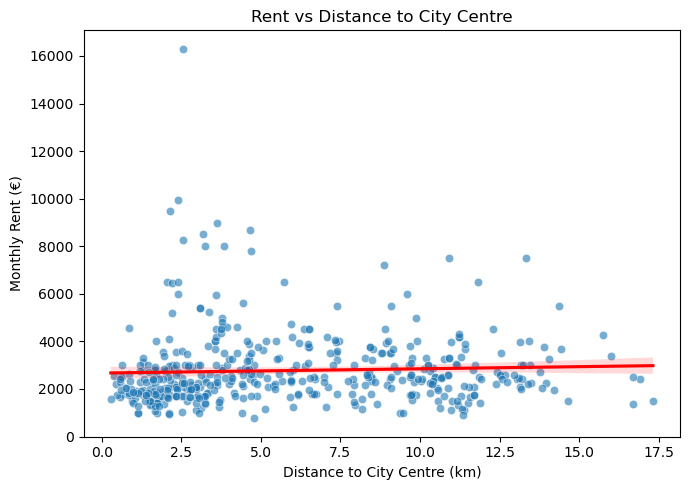

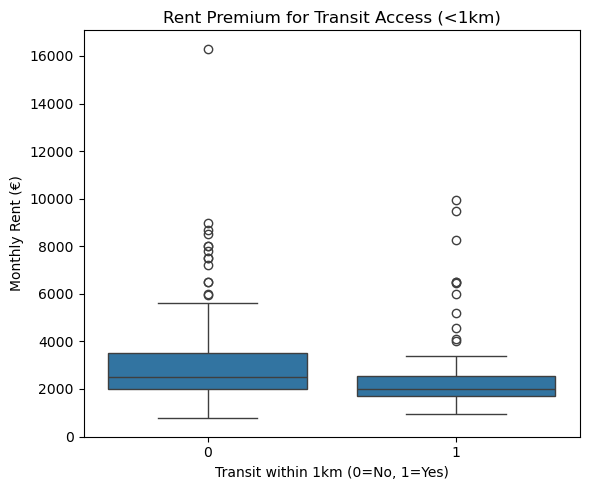

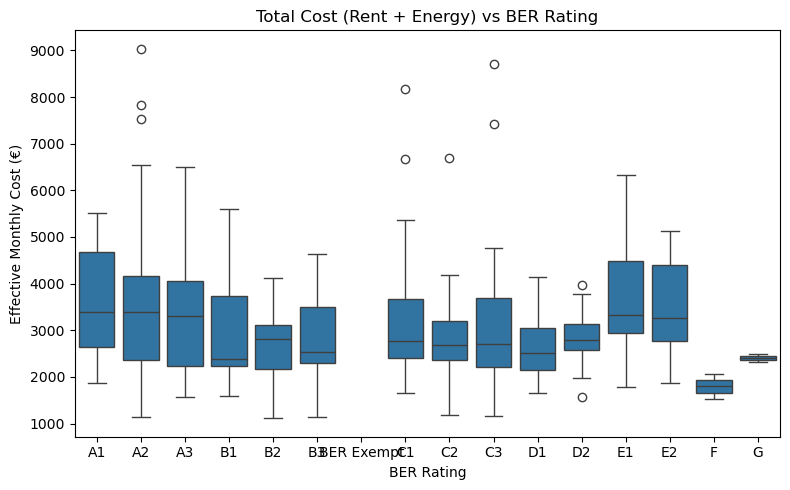

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load features_today
features = pd.read_csv("data/processed/features_today.csv")

# quick sanity
print(features.shape)
print(features.head(3))

# 2) Rent vs Distance to City Centre
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=features,
    x="distance_to_city_centre_km",
    y="Price (€)",
    alpha=0.6
)
sns.regplot(
    data=features,
    x="distance_to_city_centre_km",
    y="Price (€)",
    scatter=False,
    color="red"
)
plt.title("Rent vs Distance to City Centre")
plt.xlabel("Distance to City Centre (km)")
plt.ylabel("Monthly Rent (€)")
plt.tight_layout()
plt.savefig("docs/eda_rent_vs_distance.png", dpi=150)
plt.show()

# 3) Rent: with vs without transit <1km
if "within_1km_transit" in features.columns:
    plt.figure(figsize=(6,5))
    sns.boxplot(
        data=features,
        x="within_1km_transit",
        y="Price (€)"
    )
    plt.title("Rent Premium for Transit Access (<1km)")
    plt.xlabel("Transit within 1km (0=No, 1=Yes)")
    plt.ylabel("Monthly Rent (€)")
    plt.tight_layout()
    plt.savefig("docs/eda_rent_vs_transit.png", dpi=150)
    plt.show()

# 4) Rent + Utilities vs BER Rating
if {"BER Rating","effective_monthly_cost"}.issubset(features.columns):
    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=features,
        x="BER Rating",
        y="effective_monthly_cost",
        order=sorted(features["BER Rating"].dropna().unique())
    )
    plt.title("Total Cost (Rent + Energy) vs BER Rating")
    plt.xlabel("BER Rating")
    plt.ylabel("Effective Monthly Cost (€)")
    plt.tight_layout()
    plt.savefig("docs/eda_cost_vs_ber.png", dpi=150)
    plt.show()


In [58]:
# Rent difference: with vs without transit <1km
if "within_1km_transit" in features.columns:
    transit_means = features.groupby("within_1km_transit")["Price (€)"].mean()
    print("Average rent (no transit <1km):", round(transit_means.get(0, float("nan")),0))
    print("Average rent (transit <1km):", round(transit_means.get(1, float("nan")),0))
    print("Δ premium:", round(transit_means.get(1,0) - transit_means.get(0,0),0))

# Cost difference by BER Rating
if {"BER Rating","effective_monthly_cost"}.issubset(features.columns):
    ber_means = features.groupby("BER Rating")["effective_monthly_cost"].mean().sort_index()
    print("\nAverage total cost by BER:")
    print(ber_means)


Average rent (no transit <1km): 2894.0
Average rent (transit <1km): 2422.0
Δ premium: -472.0

Average total cost by BER:
BER Rating
A1            3608.833333
A2            3696.314286
A3            3380.190476
B1            3055.666667
B2            2711.619048
B3            2829.043478
BER Exempt            NaN
C1            3183.731707
C2            2836.888889
C3            3111.282051
D1            2596.100000
D2            2798.666667
E1            3759.571429
E2            3515.714286
F             1799.000000
G             2406.000000
Name: effective_monthly_cost, dtype: float64


C:\Users\Lee\AppData\Local\Temp\ipykernel_18708\1358737771.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_means = features.groupby("distance_band")["Price (€)"].mean().reset_index()


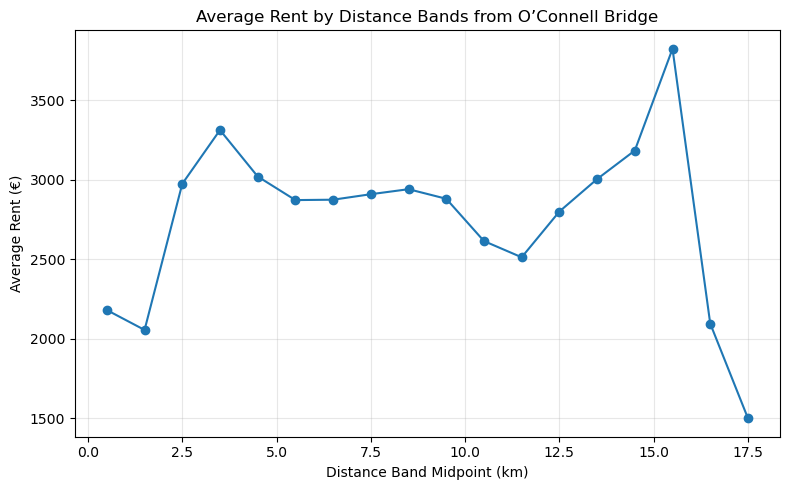

In [59]:
import numpy as np

# Create 1 km bins
features["distance_band"] = pd.cut(
    features["distance_to_city_centre_km"],
    bins=np.arange(0, features["distance_to_city_centre_km"].max()+1, 1),
    include_lowest=True
)

# Average rent per band
band_means = features.groupby("distance_band")["Price (€)"].mean().reset_index()

# Convert interval to numeric midpoint for plotting
band_means["band_midpoint"] = band_means["distance_band"].apply(lambda x: x.mid)

# Plot
plt.figure(figsize=(8,5))
plt.plot(band_means["band_midpoint"], band_means["Price (€)"], marker="o")
plt.title("Average Rent by Distance Bands from O’Connell Bridge")
plt.xlabel("Distance Band Midpoint (km)")
plt.ylabel("Average Rent (€)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("docs/eda_rent_distance_bands.png", dpi=150)
plt.show()


In [60]:
# 1) Load your features_today (from Session 2)
features = pd.read_csv("data/processed/features_today.csv")

# 2) Load the CSO LEA income data
income = pd.read_csv("income.csv")

print("Income dataset preview:")
print(income.head())
print(income.columns)

Income dataset preview:
                 Statistic Label  Year             CSO Local Electoral Areas  \
0  Median Gross Household Income  2022                   Lucan, South Dublin   
1  Median Gross Household Income  2022        Tallaght Central, South Dublin   
2  Median Gross Household Income  2022  Rathfarnham-Templeogue, South Dublin   
3  Median Gross Household Income  2022  Firhouse-Bohernabreena, South Dublin   
4  Median Gross Household Income  2022          Tallaght South, South Dublin   

  UNIT  VALUE  
0    €  85495  
1    €  56410  
2    €  79927  
3    €  86729  
4    €  59800  
Index(['Statistic Label', 'Year', 'CSO Local Electoral Areas', 'UNIT',
       'VALUE'],
      dtype='object')


In [61]:
# Keep only relevant columns, filter to 2022
income_2022 = income.query("Year == 2022")[["CSO Local Electoral Areas", "VALUE"]].copy()
income_2022.rename(columns={
    "CSO Local Electoral Areas": "LEA",
    "VALUE": "median_income_annual"
}, inplace=True)

print("Unique LEAs:", income_2022["LEA"].nunique())
print(income_2022.head())


Unique LEAs: 18
                                    LEA  median_income_annual
0                   Lucan, South Dublin                 85495
1        Tallaght Central, South Dublin                 56410
2  Rathfarnham-Templeogue, South Dublin                 79927
3  Firhouse-Bohernabreena, South Dublin                 86729
4          Tallaght South, South Dublin                 59800


In [62]:
# --- CSO LEA income → Rent-to-income enrichment (single cell) ---
import os, re
import numpy as np
import pandas as pd

os.makedirs("data/processed", exist_ok=True)

# 1) Load data
features = pd.read_csv("data/processed/features_today.csv")
income   = pd.read_csv("income.csv")

# 2) Clean CSO (keep LEA + 2022 median income)
income_2022 = (
    income.query("Year == 2022")[["CSO Local Electoral Areas", "VALUE"]]
    .rename(columns={
        "CSO Local Electoral Areas": "LEA",
        "VALUE": "median_income_annual"
    })
    .dropna(subset=["LEA", "median_income_annual"])
    .copy()
)
income_2022["LEA"] = income_2022["LEA"].str.strip()
leas = income_2022["LEA"].unique().tolist()

print("Income rows (2022):", len(income_2022), "| Unique LEAs:", income_2022["LEA"].nunique())

# 3) Pick the best text column to match (district if present, else an area extracted from Address)
def extract_area_from_address(addr: str) -> str:
    if pd.isna(addr): return ""
    parts = [p.strip() for p in str(addr).split(",") if p and p.strip()]
    cleaned = []
    for p in parts:
        low = p.lower()
        # strip generic tokens and postcode-like bits (Dublin 6, D6W, etc.)
        if low == "dublin" or low.startswith("dublin "): 
            continue
        if re.fullmatch(r"dublin\s*\d+\w*", low): 
            continue
        if re.fullmatch(r"d\s*\d+\w*", low): 
            continue
        cleaned.append(p)
    # take the last 1–2 tokens, which are usually the area names (e.g., "Rathmines", "Tallaght South")
    return " ".join(cleaned[-2:]) if cleaned else str(addr)

candidate_cols = ["dublin_district", "district_group", "Address"]
text_col = next((c for c in candidate_cols if c in features.columns), None)
if text_col is None:
    features["_match_text"] = features["Address"].apply(extract_area_from_address)
else:
    features["_match_text"] = features[text_col].fillna("").astype(str)

print("Using text column for LEA matching:", text_col or "Address (area extracted)")

# 4) Normalization + matcher (rapidfuzz if available; else simple overlap)
def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"\bdublin\b", " ", s)
    s = re.sub(r"\bireland\b", " ", s)
    s = re.sub(r"\bco\.?\b", " ", s)
    s = re.sub(r"[0-9]{1,2}\s*[a-z]?\b", " ", s)   # strip "6W", "24", etc.
    s = re.sub(r"[^a-z\s\-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

try:
    from rapidfuzz import process, fuzz
    use_lib = "rapidfuzz"
except Exception:
    use_lib = "simple"

leas_norm = [(lea, normalize_text(lea)) for lea in leas]

def simple_overlap_best(q_norm: str):
    a_tokens = set(q_norm.split())
    best, best_score = None, 0
    for lea, lea_norm in leas_norm:
        b_tokens = set(lea_norm.split())
        # Jaccard-like overlap (%)
        score = 100 * len(a_tokens & b_tokens) / max(1, len(a_tokens | b_tokens))
        if score > best_score:
            best, best_score = lea, score
    return best, best_score

ACCEPT = 75  # loosened threshold for higher coverage

def best_match(text: str, accept_threshold=ACCEPT):
    q = normalize_text(text)
    if not q:
        return None, np.nan
    if use_lib == "rapidfuzz":
        choices = [t[1] for t in leas_norm]  # normalized choices
        best_norm, score, idx = process.extractOne(q, choices, scorer=fuzz.token_set_ratio)
        best_lea = leas_norm[idx][0]
        return (best_lea, float(score)) if score >= accept_threshold else (None, float(score))
    else:
        best_lea, score = simple_overlap_best(q)
        return (best_lea, float(score)) if score >= accept_threshold else (None, float(score))

# 5) Apply matching
matches = features["_match_text"].apply(lambda x: best_match(x, accept_threshold=ACCEPT))
features["LEA_match"] = matches.apply(lambda t: t[0] if isinstance(t, tuple) else None)
features["LEA_match_score"] = matches.apply(lambda t: t[1] if isinstance(t, tuple) else np.nan)

# 6) Coverage report (and peek)
total = len(features)
matched = features["LEA_match"].notna().sum()
print(f"Match coverage: {matched}/{total} ({matched/total:.1%}) accepted at score ≥ {ACCEPT}")
print("Sample matches:")
print(features[["_match_text","LEA_match","LEA_match_score"]].head(10).to_string(index=False))

# 7) Merge income + compute rent-to-income ratio
features_income = features.merge(income_2022, left_on="LEA_match", right_on="LEA", how="left")
features_income["median_income_monthly"] = features_income["median_income_annual"] / 12.0
features_income["rent_to_income_ratio"] = features_income["Price (€)"] / features_income["median_income_monthly"]

# 8) Save output
out_path = "data/processed/features_with_income.csv"
features_income.to_csv(out_path, index=False)
print("✅ Saved:", out_path)
print(features_income[["Address","Price (€)","LEA_match","median_income_annual","rent_to_income_ratio"]].head(10).to_string(index=False))


Income rows (2022): 72 | Unique LEAs: 18
Using text column for LEA matching: Address
Match coverage: 23/470 (4.9%) accepted at score ≥ 75
Sample matches:
                                                 _match_text LEA_match  LEA_match_score
           37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W      None        39.215686
      12 Larkfield Glade, Dublin 18, Leopardstown, Dublin 18      None        36.363636
                             Grove Park, Rathmines, Dublin 6      None        52.380952
                         Frankfort Avenue, Rathgar, Dublin 6      None        40.000000
                   Phibsborough Road, Phibsborough, Dublin 7      None        38.709677
40 Diswellstown Drive, Hamilton Park, Castleknock, Dublin 15      None        34.285714
          Killinarden Estate, Dublin 24, Tallaght, Dublin 24      None        72.727273
                     Smithfield Market, Smithfield, Dublin 7      None        36.842105
                 Warner's Lane, Dublin 6, Ranelagh, Du

In [63]:
df_master.head()


,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km,...,nearest_beach_name,nearest_gym_name,nearest_supermarket_name,nearest_bus_stop_name,nearest_rail_station_name,nearest_tram_stop_name,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3,3,House,C1,4000.0,53.306745,-6.288758,4.014,...,Sandymount Strand,FlyeFit Georges St,Lidl Rathmines,Leeson St Lwr Stop,Heuston Station,Charlemont Luas,5.147042,1333.333333,140.0,4140.0
1,https://www.daft.ie/for-rent/apartment-the-pin...,"The Pines, Herbert Park Lane, Ballsbridge, Dub...",2,2,Apartment,C1,3178.0,38.159301,-78.487234,5586.767,...,Sandymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,5591.434238,1589.000000,140.0,3318.0
2,https://www.daft.ie/for-rent/apartment-2-bedro...,"2 Bedroom Apartment , Shackleton Point, Shackl...",2,2,Apartment,A2,2259.0,44.995162,-83.871560,5429.090,...,Sandymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,5433.629838,1129.500000,50.0,2309.0
3,https://www.daft.ie/for-rent/house-12-larkfiel...,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",4,3,House,A3,3995.0,53.257695,-6.200285,9.634,...,Killiney Beach,Raw Gyms Sandyford,SuperValu Balally,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,10.990601,998.750000,50.0,4045.0
4,https://www.daft.ie/for-rent/apartment-newmark...,"Newmarket Yards - 1 Bed, Newmarket Yards, Dubl...",1,1,Apartment,A2,2295.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2295.000000,50.0,2345.0


In [64]:
df_clean.head()


,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km,...,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost,energy_estimate_available,effective_cost_display,min_transit_km,within_500m_transit,within_1km_transit,Bedrooms_int
0,https://www.daft.ie/for-rent/house-37-rathdown...,"37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W",3,3,House,C1,4000.0,53.306745,-6.288758,4.014,...,5.147049,1333.333333,166.0,4166.0,True,4166.0,3.235,0,0,3
1,https://www.daft.ie/for-rent/house-12-larkfiel...,"12 Larkfield Glade, Dublin 18, Leopardstown, D...",4,3,House,A3,3995.0,53.257695,-6.200285,9.634,...,10.990616,998.75,64.0,4059.0,True,4059.0,8.854,0,0,4
2,https://www.daft.ie/for-rent/apartment--grove-...,"Grove Park, Rathmines, Dublin 6",1,1,Studio,BER Exempt,2100.0,53.329171,-6.267442,1.147,...,2.342351,2100.0,NaN,NaN,False,2100.0,0.614,0,1,1
3,https://www.daft.ie/for-rent/house-frankfort-a...,"Frankfort Avenue, Rathgar, Dublin 6",3,3,House,BER Exempt,4617.0,53.316126,-6.267333,2.515,...,3.773404,1539.0,NaN,NaN,False,4617.0,1.596,0,0,3
4,https://www.daft.ie/for-rent/flat-phibsborough...,"Phibsborough Road, Phibsborough, Dublin 7",1,1,Studio,C1,1500.0,53.363296,-6.272318,2.925,...,1.699504,1500.0,166.0,1666.0,True,1666.0,0.256,1,1,1


In [65]:
print(df_clean.columns.tolist())

['URL', 'Address', 'Bedrooms', 'Bathrooms', 'Property Type', 'BER Rating', 'Price (€)', 'lat', 'lon', 'nearest_park_km', 'nearest_beach_km', 'nearest_gym_km', 'nearest_supermarket_km', 'nearest_bus_stop_km', 'nearest_rail_station_km', 'nearest_tram_stop_km', 'nearest_park_name', 'nearest_beach_name', 'nearest_gym_name', 'nearest_supermarket_name', 'nearest_bus_stop_name', 'nearest_rail_station_name', 'nearest_tram_stop_name', 'bad_geocode', 'distance_to_city_centre_km', 'price_per_bedroom', 'energy_monthly_estimate', 'effective_monthly_cost', 'energy_estimate_available', 'effective_cost_display', 'min_transit_km', 'within_500m_transit', 'within_1km_transit', 'Bedrooms_int']


In [66]:
# --- Validate LEA/ED boundary files and prep clean copies (EPSG:4326) ---
from pathlib import Path
import geopandas as gpd

# 1) Point this to the folder you showed in your screenshot
GEO_DIR = Path("Data_external_geo")   # change if your path is different

ED_SRC  = GEO_DIR / "CSO_Electoral_Divisions_National_Statistical_Boundaries_2022_Ungeneralised.geojson"
LEA_SRC = GEO_DIR / "Local_Electoral_Areas.geojson"

assert ED_SRC.exists(),  f"Missing: {ED_SRC}"
assert LEA_SRC.exists(), f"Missing: {LEA_SRC}"

# 2) Read
ed  = gpd.read_file(ED_SRC)
lea = gpd.read_file(LEA_SRC)

print("ED rows:", len(ed),  "| CRS:", ed.crs)
print("LEA rows:", len(lea), "| CRS:", lea.crs)

print("\nED columns:", list(ed.columns)[:20], "…")
print("LEA columns:", list(lea.columns)[:20], "…")

# 3) Reproject to WGS84 (EPSG:4326) to match your lat/lon
if ed.crs is None or ed.crs.to_epsg() != 4326:
    ed = ed.to_crs(epsg=4326)
if lea.crs is None or lea.crs.to_epsg() != 4326:
    lea = lea.to_crs(epsg=4326)

# 4) Save cleaned copies with simple names
ED_OUT  = GEO_DIR / "ed_2022_4326.geojson"
LEA_OUT = GEO_DIR / "lea_2019_4326.geojson"
ed.to_file(ED_OUT, driver="GeoJSON")
lea.to_file(LEA_OUT, driver="GeoJSON")

print("\n✅ Wrote cleaned layers:")
print(" -", ED_OUT)
print(" -", LEA_OUT)

# 5) Quick accept checks (rule-of-thumb)
print("\nAccept checks (rough):")
print(" - ED polygon count should be ~3,300–3,500")
print(" - LEA polygon count should be ~160–180")
print(" - Both layers should report CRS EPSG:4326 now")


ED rows: 3420 | CRS: EPSG:2157
LEA rows: 166 | CRS: EPSG:4326

ED columns: ['OBJECTID', 'ED_GUID', 'ED_OFFICIAL', 'ED_ENGLISH', 'ED_GAEILGE', 'ED_ID_STR', 'ED_PART_COUNT', 'COUNTY_CODE', 'COUNTY_ENGLISH', 'COUNTY_GAEILGE', 'CSO_LEA', 'geometry'] …
LEA columns: ['LE_ID', 'ENGLISH', 'GAEILGE', 'CONTAE', 'COUNTY', 'PROVINCE', 'GUID', 'CENTROID_X', 'CENTROID_Y', 'AREA', 'ESRI_OID', 'geometry'] …

✅ Wrote cleaned layers:
 - Data_external_geo\ed_2022_4326.geojson
 - Data_external_geo\lea_2019_4326.geojson

Accept checks (rough):
 - ED polygon count should be ~3,300–3,500
 - LEA polygon count should be ~160–180
 - Both layers should report CRS EPSG:4326 now


In [67]:
# --- Spatial join (fix index_right conflict) + nearest fallback ---
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path

PROCESSED_DIR = Path("data/processed")
GEO_DIR       = Path("Data_external_geo")

FEATURES_IN = PROCESSED_DIR / "features_today.csv"
LEA_PATH    = GEO_DIR / "lea_2019_4326.geojson"
ED_PATH     = GEO_DIR / "ed_2022_4326.geojson"

# 1) Load data
df = pd.read_csv(FEATURES_IN)
assert {"lat","lon"}.issubset(df.columns), "Expected lat/lon columns."
gdf = gpd.GeoDataFrame(df.copy(),
                       geometry=gpd.points_from_xy(df["lon"], df["lat"]),
                       crs="EPSG:4326")

lea = gpd.read_file(LEA_PATH).to_crs(4326)
ed  = gpd.read_file(ED_PATH).to_crs(4326)

print("LEA polygons:", len(lea), "| ED polygons:", len(ed))

# 2) Name/code fields
lea_name_col, lea_code_col = "ENGLISH", "LE_ID"
ed_name_col,  ed_code_col  = "ED_ENGLISH", "ED_GUID"

# 3) Join to LEA (within)
gdf_lea = gpd.sjoin(
    gdf, lea[[lea_name_col, lea_code_col, "geometry"]],
    how="left", predicate="within"
)
# IMPORTANT: drop index_right before doing the next sjoin
if "index_right" in gdf_lea.columns:
    gdf_lea = gdf_lea.drop(columns="index_right")

gdf_lea = gdf_lea.rename(columns={lea_name_col: "LEA_NAME", lea_code_col: "LEA_CODE"})

# 4) Join to ED (within)
gdf_ed = gpd.sjoin(
    gdf_lea, ed[[ed_name_col, ed_code_col, "geometry"]],
    how="left", predicate="within"
)
if "index_right" in gdf_ed.columns:
    gdf_ed = gdf_ed.drop(columns="index_right")

gdf_ed = gdf_ed.rename(columns={ed_name_col: "ED_NAME", ed_code_col: "ED_CODE"})

# 5) Coverage
n = len(gdf_ed)
lea_ok = gdf_ed["LEA_NAME"].notna().sum()
ed_ok  = gdf_ed["ED_NAME"].notna().sum()
print(f"Coverage (within): LEA {lea_ok}/{n} ({lea_ok/n:.1%}), ED {ed_ok}/{n} ({ed_ok/n:.1%})")

# 6) Fallback: nearest polygon for any remaining NaNs (within ~50 m)
needs_fallback = (lea_ok < n) or (ed_ok < n)
if needs_fallback:
    print("Applying nearest-polygon fallback (~50 m)…")
    if (gdf_ed["LEA_NAME"].isna()).any():
        miss = gdf_ed[gdf_ed["LEA_NAME"].isna()]
        near = gpd.sjoin_nearest(miss, lea[[lea_name_col, lea_code_col, "geometry"]],
                                 how="left", max_distance=0.0005)  # ~55 m at Dublin lat
        gdf_ed.loc[miss.index, "LEA_NAME"] = near[lea_name_col].values
        gdf_ed.loc[miss.index, "LEA_CODE"] = near[lea_code_col].values

    if (gdf_ed["ED_NAME"].isna()).any():
        miss = gdf_ed[gdf_ed["ED_NAME"].isna()]
        near = gpd.sjoin_nearest(miss, ed[[ed_name_col, ed_code_col, "geometry"]],
                                 how="left", max_distance=0.0005)
        gdf_ed.loc[miss.index, "ED_NAME"] = near[ed_name_col].values
        gdf_ed.loc[miss.index, "ED_CODE"] = near[ed_code_col].values

    lea_ok = gdf_ed["LEA_NAME"].notna().sum()
    ed_ok  = gdf_ed["ED_NAME"].notna().sum()
    print(f"Coverage (after nearest): LEA {lea_ok}/{n} ({lea_ok/n:.1%}), ED {ed_ok}/{n} ({ed_ok/n:.1%})")

# 7) Save
OUT_CSV  = PROCESSED_DIR / "features_lea_ed.csv"
OUT_GPKG = PROCESSED_DIR / "features_lea_ed.gpkg"
gdf_ed.drop(columns="geometry").to_csv(OUT_CSV, index=False)
gdf_ed.to_file(OUT_GPKG, layer="listings", driver="GPKG")

print("\n✅ Saved:")
print(" -", OUT_CSV)
print(" -", OUT_GPKG)

print("\nSample:")
print(gdf_ed[["Address","LEA_NAME","ED_NAME"]].head(10).to_string(index=False))


LEA polygons: 166 | ED polygons: 3420
Coverage (within): LEA 470/470 (100.0%), ED 470/470 (100.0%)

✅ Saved:
 - data\processed\features_lea_ed.csv
 - data\processed\features_lea_ed.gpkg

Sample:
                                                     Address                   LEA_NAME                 ED_NAME
           37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W    KIMMAGE-RATHMINES LEA-6              TERENURE D
      12 Larkfield Glade, Dublin 18, Leopardstown, Dublin 18 GLENCULLEN-SANDYFORD LEA-7              GLENCULLEN
                             Grove Park, Rathmines, Dublin 6    KIMMAGE-RATHMINES LEA-6        RATHMINES WEST A
                         Frankfort Avenue, Rathgar, Dublin 6    KIMMAGE-RATHMINES LEA-6        RATHMINES WEST D
                   Phibsborough Road, Phibsborough, Dublin 7      CABRA-GLASNEVIN LEA-7            CABRA EAST A
40 Diswellstown Drive, Hamilton Park, Castleknock, Dublin 15          CASTLEKNOCK LEA-6 CASTLEKNOCK-KNOCKMAROON
          Killinarden

In [68]:
import pandas as pd

# Paths (change if yours differ)
master = pd.read_csv("rentals_master.csv")
clean  = pd.read_csv("rentals_master_clean.csv")
feat   = pd.read_csv("data/processed/features_lea_ed.csv")  # the one we just saved

def amenity_cols(df):
    cols = [c for c in df.columns if c.startswith("nearest_")]
    # keep distance/name pairs together
    order = sorted(cols, key=lambda x: (x.rsplit("_",1)[0], x.endswith("_km") is False))
    return order

print("=== Shapes ===")
print("master:", master.shape, "| clean:", clean.shape, "| features_lea_ed:", feat.shape)

print("\n=== Amenity columns present (master) ===")
m_cols = amenity_cols(master); print(m_cols)

print("\n=== Amenity columns present (clean) ===")
c_cols = amenity_cols(clean);  print(c_cols)

print("\n=== Amenity columns present (features_lea_ed) ===")
f_cols = amenity_cols(feat);   print(f_cols)

print("\n=== Overlap & gaps (relative to master) ===")
print("In master ONLY (missing downstream):", sorted(set(m_cols) - set(f_cols)))
print("Already in features_lea_ed:", sorted(set(m_cols) & set(f_cols)))

# Quick completeness check for master amenity km fields
km_cols = [c for c in m_cols if c.endswith("_km")]
miss = master[km_cols].isna().mean().sort_values(ascending=False) if km_cols else pd.Series(dtype=float)
print("\n=== Missingness in master (amenity *_km) ===")
print((miss*100).round(1).to_string())

# Sanity: are URLs good join keys?
dups_master = master.duplicated("URL").sum() if "URL" in master.columns else "no URL col"
dups_clean  = clean.duplicated("URL").sum()  if "URL" in clean.columns  else "no URL col"
print("\n=== URL duplicates ===")
print("master:", dups_master, "| clean:", dups_clean)

# Peek a few rows to see units/strings
peek_cols = ["Address","URL"] + m_cols[:6]  # small sample
print("\n=== Sample (master) ===")
print(master[peek_cols].head(5).to_string(index=False))


=== Shapes ===
master: (1134, 41) | clean: (470, 30) | features_lea_ed: (470, 30)

=== Amenity columns present (master) ===
['nearest_beach_km', 'nearest_beach_name', 'nearest_beach_km_y', 'nearest_beach_name_y', 'nearest_bus_stop_km', 'nearest_bus_stop_name', 'nearest_bus_stop_km_y', 'nearest_bus_stop_name_y', 'nearest_gym_km', 'nearest_gym_name', 'nearest_gym_km_y', 'nearest_gym_name_y', 'nearest_park_km', 'nearest_park_name', 'nearest_park_km_y', 'nearest_park_name_y', 'nearest_rail_station_km', 'nearest_rail_station_name', 'nearest_rail_station_km_y', 'nearest_rail_station_name_y', 'nearest_supermarket_km', 'nearest_supermarket_name', 'nearest_supermarket_km_y', 'nearest_supermarket_name_y', 'nearest_tram_stop_km', 'nearest_tram_stop_name', 'nearest_tram_stop_km_y', 'nearest_tram_stop_name_y']

=== Amenity columns present (clean) ===
['nearest_beach_km_y', 'nearest_beach_name_y', 'nearest_bus_stop_km_y', 'nearest_bus_stop_name_y', 'nearest_gym_km_y', 'nearest_gym_name_y', 'nearest_

In [69]:
# --- Checklist #2 (v2): Consolidate amenities + flags (fixed transit min) ---
import os
import pandas as pd
import numpy as np

os.makedirs("data/processed", exist_ok=True)

master = pd.read_csv("rentals_master.csv")
feat   = pd.read_csv("data/processed/features_lea_ed.csv")

assert "URL" in master.columns and "URL" in feat.columns, "Expected 'URL' key in both tables."
print(f"Rows — master: {len(master)}, features_lea_ed: {len(feat)}")

amenities = ["beach","bus_stop","gym","park","rail_station","supermarket","tram_stop"]

def coalesce_columns(df, candidates, as_numeric=False):
    present = [c for c in candidates if c in df.columns]
    # start with the first present column (avoids FutureWarning on empty combine_first)
    if not present:
        return pd.Series(index=df.index, dtype=("float64" if as_numeric else "object"))
    base = df[present[0]]
    out = (pd.to_numeric(base, errors="coerce") if as_numeric else base.astype("object")).copy()
    for c in present[1:]:
        if as_numeric:
            out = out.combine_first(pd.to_numeric(df[c], errors="coerce"))
        else:
            out = out.combine_first(df[c].astype("object"))
    return out

# Build canonical subset from master
canon = pd.DataFrame({"URL": master["URL"]})
for a in amenities:
    canon[f"nearest_{a}_km_master"]   = coalesce_columns(master, [f"nearest_{a}_km", f"nearest_{a}_km_y"], as_numeric=True)
    canon[f"nearest_{a}_name_master"] = coalesce_columns(master, [f"nearest_{a}_name", f"nearest_{a}_name_y"], as_numeric=False)

merged = feat.merge(canon, on="URL", how="left")

# Consolidate into single canonical columns in merged
for a in amenities:
    km_feat = f"nearest_{a}_km"
    km_m    = f"nearest_{a}_km_master"
    nm_feat = f"nearest_{a}_name"
    nm_m    = f"nearest_{a}_name_master"

    # distances (km)
    if km_feat in merged.columns:
        merged[km_feat] = pd.to_numeric(merged[km_feat], errors="coerce").combine_first(merged[km_m])
    else:
        merged[km_feat] = merged[km_m]

    # clip impossible huge values (protect against unit glitches)
    merged.loc[merged[km_feat] > 100, km_feat] = np.nan

    # names
    if nm_feat in merged.columns:
        merged[nm_feat] = merged[nm_feat].astype("object").fillna(merged[nm_m])
    else:
        merged[nm_feat] = merged[nm_m]

    # drop helpers
    merged.drop(columns=[col for col in [km_m, nm_m] if col in merged.columns], inplace=True)

# Proximity flags per amenity
for a in amenities:
    km_col = f"nearest_{a}_km"
    if km_col in merged.columns:
        merged[f"nearest_{a}_within_500m"] = (pd.to_numeric(merged[km_col], errors="coerce") <= 0.5).astype("Int64")
        merged[f"nearest_{a}_within_1km"]  = (pd.to_numeric(merged[km_col], errors="coerce") <= 1.0).astype("Int64")

# Transit rollups
transit_cols = [c for c in ["nearest_tram_stop_km","nearest_bus_stop_km","nearest_rail_station_km"] if c in merged.columns]
if transit_cols:
    num_transit = merged[transit_cols].apply(pd.to_numeric, errors="coerce")
    merged["min_transit_km"] = num_transit.min(axis=1)
    merged["within_500m_transit"] = (merged["min_transit_km"] <= 0.5).astype("Int64")
    merged["within_1km_transit"]  = (merged["min_transit_km"] <= 1.0).astype("Int64")

# Coverage table
km_cols = [c for c in merged.columns if c.startswith("nearest_") and c.endswith("_km")]
coverage = (1 - merged[km_cols].isna().mean()).sort_values(ascending=False) * 100 if km_cols else pd.Series(dtype=float)
print("\n=== Amenity distance coverage (non-null %) ===")
print(coverage.round(1).to_string() if not coverage.empty else "No *_km columns found.")

# Save
out_path = "data/processed/features_amenities.csv"
merged.to_csv(out_path, index=False)
print(f"\n✅ Saved: {out_path} | Rows: {merged.shape[0]} | Cols: {merged.shape[1]}")

# Preview
preview_cols = [
    "Address","Price (€)",
    "nearest_tram_stop_km","nearest_bus_stop_km","nearest_rail_station_km",
    "min_transit_km","within_500m_transit","within_1km_transit",
    "nearest_supermarket_km","nearest_supermarket_name",
    "nearest_park_km","nearest_park_name",
    "nearest_beach_km","nearest_beach_name"
]
print("\n=== Sample ===")
print(merged[[c for c in preview_cols if c in merged.columns]].head(8).to_string(index=False))


Rows — master: 1134, features_lea_ed: 470

=== Amenity distance coverage (non-null %) ===
nearest_beach_km           100.0
nearest_bus_stop_km        100.0
nearest_gym_km             100.0
nearest_park_km            100.0
nearest_rail_station_km    100.0
nearest_supermarket_km     100.0
nearest_tram_stop_km       100.0

✅ Saved: data/processed/features_amenities.csv | Rows: 470 | Cols: 51

=== Sample ===
                                                     Address  Price (€)  nearest_tram_stop_km  nearest_bus_stop_km  nearest_rail_station_km  min_transit_km  within_500m_transit  within_1km_transit  nearest_supermarket_km nearest_supermarket_name  nearest_park_km   nearest_park_name  nearest_beach_km nearest_beach_name
           37 Rathdown Drive, Dublin 6w, Terenure, Dublin 6W     4000.0                 3.235                3.602                    4.469           3.235                    0                   0                   2.259           Lidl Rathmines            4.014  St Steph

In [70]:
!pip install openpyxl

In [71]:
import pandas as pd
from pathlib import Path

files = [
    Path("data/mainstream-schools_dublin_2019-2020.xlsx"),
    Path("data/post-primary-schools-2019-2020-1.xlsx"),
]

coord_like = {"lat","latitude","wgs84_latitude","lon","long","longitude","wgs84_longitude",
              "x","y","point_x","point_y","itm_e","itm_n","easting","northing","irish grid","itm"}

for f in files:
    assert f.exists(), f"Missing: {f}"
    print("\n====", f.name, "====")
    try:
        xls = pd.ExcelFile(f)
        for sh in xls.sheet_names:
            df = pd.read_excel(f, sheet_name=sh, nrows=2)  # tiny sample to get columns
            cols = [c.strip() for c in df.columns]
            hits = [c for c in cols if any(k in c.lower() for k in coord_like)]
            print(f"Sheet: {sh:>25} | ncols={len(cols)} | coord-ish: {hits[:8]}")
            print("  first columns:", cols[:10])
    except Exception as e:
        print("  (read error)", e)



==== mainstream-schools_dublin_2019-2020.xlsx ====
Sheet:                    Sheet1 | ncols=20 | coord-ish: ['County Description', 'Local Authority Description', 'Gaeltacht Indicator (Y/N)', 'DEIS (Y/N)', 'Island (Y/N)']
  first columns: ['Roll Number', 'Official Name', 'Address (Line 1)', 'Address (Line 2)', 'Address (Line 3)', 'Address (Line 4)', 'County Description', 'Local Authority Description', 'Phone No.', 'Principal Name']

==== post-primary-schools-2019-2020-1.xlsx ====
Sheet:                    Sheet1 | ncols=24 | coord-ish: ['County', 'Local Authority', 'DEIS (Y/N)', 'Gaeltacht Area Location (Y/N)', 'Island Location (Y/N)', 'Fee Paying School (Y/N)', 'Pupil Attendance Type', 'School Gender - Post Primary']
  first columns: ['Roll Number', 'Official School Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'County', 'Local Authority', 'Eircode', 'Principal Name']


In [72]:

output_path = "daft_clean.csv"
df_clean.to_csv(output_path, index=False)
print(f"✅ Saved: {output_path} with {len(df_clean)} rows")

✅ Saved: daft_clean.csv with 470 rows


In [73]:
columns = df_clean.columns.tolist()
print(columns)

['URL', 'Address', 'Bedrooms', 'Bathrooms', 'Property Type', 'BER Rating', 'Price (€)', 'lat', 'lon', 'nearest_park_km', 'nearest_beach_km', 'nearest_gym_km', 'nearest_supermarket_km', 'nearest_bus_stop_km', 'nearest_rail_station_km', 'nearest_tram_stop_km', 'nearest_park_name', 'nearest_beach_name', 'nearest_gym_name', 'nearest_supermarket_name', 'nearest_bus_stop_name', 'nearest_rail_station_name', 'nearest_tram_stop_name', 'bad_geocode', 'distance_to_city_centre_km', 'price_per_bedroom', 'energy_monthly_estimate', 'effective_monthly_cost', 'energy_estimate_available', 'effective_cost_display', 'min_transit_km', 'within_500m_transit', 'within_1km_transit', 'Bedrooms_int']


In [74]:
import pandas as pd

df = pd.read_csv("cleaned_data_enriched.csv")  # or your latest full file

# Keep only rows with valid lat/lon
df = df.dropna(subset=["lat", "lon"])

# Random 200 rows (adjust number as you like)
sample = df.sample(n=200, random_state=42)

sample.to_csv("sample.csv", index=False)



In [75]:
df = df.dropna(subset=["lat", "lon"])
sample = df.head(200)
sample.to_csv("sample.csv", index=False)

In [76]:
# === Create cleaned_data_enriched.csv from rentals_master_clean.csv ===
import pandas as pd

INPUT_FILE = "rentals_master_clean.csv"   # your master file
OUTPUT_FILE = "cleaned_data_enriched.csv"

df = pd.read_csv(INPUT_FILE)

# keep only rows with valid lat & lon
if {"lat","lon"}.issubset(df.columns):
    df = df.dropna(subset=["lat","lon"]).copy()
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df[df["lat"].between(-90, 90) & df["lon"].between(-180, 180)]

df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Saved {len(df)} rows with valid lat/lon → {OUTPUT_FILE}")


✅ Saved 470 rows with valid lat/lon → cleaned_data_enriched.csv


In [77]:
df_master.tail()

,URL,Address,Bedrooms,Bathrooms,Property Type,BER Rating,Price (€),lat,lon,nearest_park_km,...,nearest_beach_name,nearest_gym_name,nearest_supermarket_name,nearest_bus_stop_name,nearest_rail_station_name,nearest_tram_stop_name,distance_to_city_centre_km,price_per_bedroom,energy_monthly_estimate,effective_monthly_cost
1129,https://www.daft.ie/for-rent/apartment-10-lees...,"10 Leeson Court, Leeson Street Upper",2,2,Apartment,C2,3950.0,44.253783,-85.425241,5576.335,...,Sandymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,5580.871171,1975.0,140.0,4090.0
1130,https://www.daft.ie/for-rent/house-gray-street...,"Gray Street, Dublin 8",2,1,House,BER Exempt,2400.0,53.340430,-6.278793,1.331,...,Sandymount Strand,FlyeFit Georges St,Aldi Phibsborough,O'Connell St Stop,Heuston Station,St Stephen's Green Luas,1.610102,1200.0,80.0,2480.0
1131,https://www.daft.ie/for-rent/apartment-station...,"Station View , Station View, The Crossings , A...",2,2,Studio,A2,2402.0,54.253683,-6.971317,108.257,...,Dollymount Strand,Ben Dunne Gym Northside,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,110.822154,1201.0,50.0,2452.0
1132,https://www.daft.ie/for-rent/property-richmond...,"Richmond Hill, Rathmines, Dublin 6",1,1,Studio,BER Exempt,1022.0,53.327191,-6.263161,1.254,...,Sandymount Strand,FlyeFit Georges St,Lidl Rathmines,Leeson St Lwr Stop,Pearse Station,Charlemont Luas,2.521206,1022.0,80.0,1102.0
1133,https://www.daft.ie/for-rent/house-40-diswells...,"40 Diswellstown Drive, Hamilton Park, Castlekn...",4,3,House,A3,3750.0,53.366936,-6.384274,3.780,...,Sandymount Strand,FlyeFit Georges St,Aldi Phibsborough,Phibsborough Rd Stop,Heuston Station,Abbey Street Luas,8.444963,937.5,50.0,3800.0


In [78]:
df_clean2 = pd.read_csv("cleaned_data_enriched.csv")

# Quick shape check
print(f"Rows: {len(df_clean2)}, Columns: {df_clean2.shape[1]}")

# Count of missing values per column
print("\nMissing values per column:")
print(df_clean2.isna().sum())

# If you want % missing per column
print("\n% Missing values per column:")
print((df_clean2.isna().mean() * 100).round(1))

# Quick check if there are zeros in lat/lon
if "lat" in df_clean2.columns and "lon" in df_clean2.columns:
    print("\nRows with lat=0 or lon=0:", len(df_clean2[(df_clean2['lat']==0) | (df_clean2['lon']==0)]))

Rows: 470, Columns: 30

Missing values per column:
URL                              0
Address                          0
Bedrooms                         0
Bathrooms                        0
Property Type                    0
BER Rating                      47
Price (€)                        0
lat                              0
lon                              0
nearest_park_km_y                0
nearest_beach_km_y               0
nearest_gym_km_y                 0
nearest_supermarket_km_y         0
nearest_bus_stop_km_y            0
nearest_rail_station_km_y        0
nearest_tram_stop_km_y           0
nearest_park_name_y              0
nearest_beach_name_y             0
nearest_gym_name_y               0
nearest_supermarket_name_y       0
nearest_bus_stop_name_y          0
nearest_rail_station_name_y      0
nearest_tram_stop_name_y         0
bad_geocode                      0
distance_to_city_centre_km       0
price_per_bedroom                0
energy_monthly_estimate        183
effe

In [79]:
print(f"Rows: {len(df_clean2)}, Columns: {df_clean2.shape[1]}")

print("\nMissing values per column:")
print(df_clean2.isna().sum())

print("\n% Missing values per column:")
print((df_clean2.isna().mean() * 100).round(1))

if "lat" in df_clean2.columns and "lon" in df_clean2.columns:
    print("\nRows with lat=0 or lon=0:",
          len(df_clean2[(df_clean2['lat']==0) | (df_clean2['lon']==0)]))


Rows: 470, Columns: 30

Missing values per column:
URL                              0
Address                          0
Bedrooms                         0
Bathrooms                        0
Property Type                    0
BER Rating                      47
Price (€)                        0
lat                              0
lon                              0
nearest_park_km_y                0
nearest_beach_km_y               0
nearest_gym_km_y                 0
nearest_supermarket_km_y         0
nearest_bus_stop_km_y            0
nearest_rail_station_km_y        0
nearest_tram_stop_km_y           0
nearest_park_name_y              0
nearest_beach_name_y             0
nearest_gym_name_y               0
nearest_supermarket_name_y       0
nearest_bus_stop_name_y          0
nearest_rail_station_name_y      0
nearest_tram_stop_name_y         0
bad_geocode                      0
distance_to_city_centre_km       0
price_per_bedroom                0
energy_monthly_estimate        183
effe

In [80]:
import pandas as pd
import re

# Load the CSV you just checked
df = pd.read_csv("cleaned_data_enriched.csv")

# Create Bedrooms_int from the 'Bedrooms' text column
def extract_bedrooms(text):
    if pd.isna(text):
        return None
    # Try to find a number at the start or anywhere in the string
    m = re.search(r"\d+", str(text))
    if m:
        return int(m.group(0))
    return None

df["Bedrooms_int"] = df["Bedrooms"].apply(extract_bedrooms)

# Quick check
print(df["Bedrooms_int"].value_counts(dropna=False).sort_index())

# Save back
df.to_csv("cleaned_data_enriched.csv", index=False)
print("✅ Bedrooms_int regenerated and file saved")


Bedrooms_int
1    145
2    154
3     97
4     56
5     13
6      2
7      1
8      1
9      1
Name: count, dtype: int64
✅ Bedrooms_int regenerated and file saved


In [84]:
import re
import pandas as pd
import numpy as np

# ---------- load ----------
df = df_master.copy()  # use your big master DataFrame directly if it’s in memory
# OR if you don’t have it loaded:
# df = pd.read_csv("df_master.csv")

# ---------- bedrooms ----------
if "Bedrooms_int" not in df.columns:
    df["Bedrooms_int"] = (
        df.get("Bedrooms","").astype(str).str.extract(r"(\d+)").astype(float)[0].astype("Int64")
    )

# ---------- bathrooms ----------
df["Bathrooms_num"] = pd.to_numeric(df.get("Bathrooms"), errors="coerce")

# ---------- BER normalize ----------
def normalise_ber(val):
    if pd.isna(val): return "Unknown"
    s = str(val).strip()
    if s == "": return "Unknown"
    low = s.lower()
    if "exempt" in low: return "Exempt"
    s = re.sub(r"\s+", "", s.upper()).replace("-", "")
    valid = {"A1","A2","A3","B1","B2","B3","C1","C2","C3","D1","D2","E1","E2","F","G","Exempt","Unknown"}
    if s in valid: return s
    m = re.match(r"^([A-G])(\d)$", s)
    if m:
        guess = m.group(1)+m.group(2)
        return guess if guess in valid else "Unknown"
    return "Unknown"

df["BER_norm"] = df.get("BER Rating").apply(normalise_ber)

# ---------- area / eircode ----------
def extract_area(row):
    ec = row.get("Eircode", None)
    if pd.notna(ec):
        m = re.search(r"\b([ACDFHKNPRTVWXY]\d{2}|D\d{1,2})\b", str(ec).upper())
        if m: return m.group(1)
    s = str(row.get("Address", "")).upper()
    m = re.search(r"\bDUBLIN\s*(\d{1,2})\b", s)
    if m: return "D"+m.group(1)
    return "OTHER"

df["AreaCode"] = df.apply(extract_area, axis=1)

# ---------- target + features ----------
target = "Price (€)"
feature_cols = ["Bedrooms_int", "Bathrooms_num", "Property Type", "BER_norm", "AreaCode"]

work = df[feature_cols + [target]].copy()
work = work.dropna(subset=[target, "Bedrooms_int", "Bathrooms_num"])
print("Usable rows for modelling:", work.shape[0])
work.head()


Usable rows for modelling: 1134


,Bedrooms_int,Bathrooms_num,Property Type,BER_norm,AreaCode,Price (€)
0,3,3,House,C1,OTHER,4000.0
1,2,2,Apartment,C1,D4,3178.0
2,2,2,Apartment,A2,OTHER,2259.0
3,4,3,House,A3,D18,3995.0
4,1,1,Apartment,A2,D8,2295.0


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

X = work[feature_cols]
y = work[target].astype(float)

cat_cols = ["Property Type", "BER_norm", "AreaCode"]
num_cols = ["Bedrooms_int", "Bathrooms_num"]

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model = Pipeline([
    ("pre", pre),
    ("rf", rf)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

len(X_train), len(X_test)


(907, 227)

In [89]:
# ==== Model comparison (paste after Step 2) ====
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import numpy as np
import pandas as pd

# Reuse your pre (ColumnTransformer), X_train, y_train, X_test, y_test from Step 2
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Version-safe scorers
mae_scorer  = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(lambda yt, yp: mean_squared_error(yt, yp) ** 0.5, greater_is_better=False)

models = {
    "RandomForest": Pipeline([
        ("pre", pre),
        ("est", RandomForestRegressor(
            n_estimators=500, max_depth=None, min_samples_leaf=2,
            random_state=42, n_jobs=-1
        ))
    ]),
    "ExtraTrees": Pipeline([
        ("pre", pre),
        ("est", ExtraTreesRegressor(
            n_estimators=600, max_depth=None, min_samples_leaf=1,
            random_state=42, n_jobs=-1
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("pre", pre),
        ("est", GradientBoostingRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=3,
            random_state=42
        ))
    ]),
    "Ridge": Pipeline([
        ("pre", pre),
        ("est", Ridge(alpha=5.0, random_state=42))
    ]),
}

rows = []
for name, pipe in models.items():
    mae = -cross_val_score(pipe, X_train, y_train, cv=cv, scoring=mae_scorer,  n_jobs=-1)
    rmse = -cross_val_score(pipe, X_train, y_train, cv=cv, scoring=rmse_scorer, n_jobs=-1)
    r2 =  cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2",       n_jobs=-1)
    rows.append({
        "model": name,
        "CV_MAE_mean":  mae.mean(),
        "CV_MAE_std":   mae.std(),
        "CV_RMSE_mean": rmse.mean(),
        "CV_RMSE_std":  rmse.std(),
        "CV_R2_mean":   r2.mean(),
        "CV_R2_std":    r2.std()
    })

cmp_df = pd.DataFrame(rows).sort_values("CV_MAE_mean")
print("Cross-validated results (lower MAE/RMSE is better, higher R² is better):")
display(cmp_df)

# pick the best by MAE (feel free to change to RMSE if you prefer)
best_name = cmp_df.iloc[0]["model"]
best_model = models[best_name]
print(f"\nFitting best model: {best_name}")
best_model.fit(X_train, y_train)
pred_test = best_model.predict(X_test)

holdout_mae  = mean_absolute_error(y_test, pred_test)
holdout_rmse = (mean_squared_error(y_test, pred_test)) ** 0.5
holdout_r2   = r2_score(y_test, pred_test)

print("\nHoldout metrics for best model:")
print(" MAE :", f"€{holdout_mae:,.0f}")
print(" RMSE:", f"€{holdout_rmse:,.0f}")
print(" R²  :", f"{holdout_r2:.3f}")

# keep the best_model around for Step 4 if you like, or replace in Step 4:
model = best_model


Cross-validated results (lower MAE/RMSE is better, higher R² is better):


,model,CV_MAE_mean,CV_MAE_std,CV_RMSE_mean,CV_RMSE_std,CV_R2_mean,CV_R2_std
0,RandomForest,499.101349,82.690473,906.958916,293.476495,0.585476,0.047901
2,GradientBoosting,509.900910,84.070632,976.128845,297.884376,0.504085,0.147219
1,ExtraTrees,540.509145,78.699928,1037.523552,261.365168,0.432554,0.094840
3,Ridge,572.995173,57.096046,970.452954,333.244448,0.529011,0.054808



Fitting best model: RandomForest

Holdout metrics for best model:
 MAE : €448
 RMSE: €822
 R²  : 0.621


In [90]:
import joblib
import pandas as pd
import numpy as np

# --- Fit on FULL data for production use ---
model.fit(X, y)   # X, y from Step 1/2

# ---------------- Feature names (robust across sklearn versions) ---------------
preproc = model.named_steps["pre"]
ohe = preproc.named_transformers_["cat"].named_steps["ohe"]

try:
    cat_feat_names = ohe.get_feature_names_out(input_features=["Property Type","BER_norm","AreaCode"]).tolist()
except AttributeError:
    cat_feat_names = ohe.get_feature_names(input_features=["Property Type","BER_norm","AreaCode"]).tolist()

num_feat_names = ["Bedrooms_int","Bathrooms_num"]
all_feat_names = num_feat_names + cat_feat_names

# ---------------- Importances / Coeffs (works for tree & linear) ---------------
est = model.named_steps["est"]  # <-- use 'est' (not 'rf')
fi = None
if hasattr(est, "feature_importances_"):
    importances = est.feature_importances_
    fi = pd.DataFrame({"feature": all_feat_names, "importance": importances}) \
            .sort_values("importance", ascending=False)
elif hasattr(est, "coef_"):
    # Ridge or linear-like model (coef_ shape: [n_features] or [1, n_features])
    coefs = est.coef_.ravel()
    fi = pd.DataFrame({"feature": all_feat_names, "importance": np.abs(coefs)}) \
            .sort_values("importance", ascending=False)
else:
    # Fallback: no importances available
    fi = pd.DataFrame({"feature": all_feat_names, "importance": np.nan})

# Save and preview top importances
fi.to_csv("feature_importances.csv", index=False)
display(fi.head(20))

# ---------------- Save model ----------------
joblib.dump(model, "price_model.pkl")   # generic name (might not be RF)

# ---------------- Predictions snapshot (for app merge) ---------------
# Use whatever ID is present; URL preferred
id_col = "URL" if "URL" in df.columns else ("Address" if "Address" in df.columns else None)
snap_cols = [c for c in ["URL","Address","Bedrooms","Bathrooms","Property Type","BER_norm","AreaCode","Price (€)"] if c in df.columns]
snap = df[snap_cols].copy()

# Predict on the rows used to build X
snap["pred_price"] = model.predict(df[["Bedrooms_int","Bathrooms_num","Property Type","BER_norm","AreaCode"]])
if "Price (€)" in snap.columns:
    snap["abs_error"] = (snap["Price (€)"] - snap["pred_price"]).abs()
    snap["delta_pct"] = 100 * (snap["Price (€)"] - snap["pred_price"]) / snap["pred_price"]

snap.to_csv("predictions_snapshot.csv", index=False)
print("Saved: price_model.pkl, feature_importances.csv, predictions_snapshot.csv")

# ---------------- Optional: write a fully merged CSV for the app ----------------
# If your app currently loads 'cleaned_data_enriched.csv', you can create a
# convenience file that already includes the predictions and delta columns.
try:
    base = pd.read_csv("cleaned_data_enriched.csv")
    if id_col and id_col in base.columns and id_col in snap.columns:
        merged = base.merge(snap[[id_col, "pred_price", "delta_pct"]], on=id_col, how="left")
        merged["Fairness_Delta"] = merged["Price (€)"] - merged["pred_price"]
        merged.to_csv("cleaned_data_enriched_with_fairness.csv", index=False)
        print("Also saved: cleaned_data_enriched_with_fairness.csv")
    else:
        print("Note: could not create merged file (no shared key column).")
except FileNotFoundError:
    print("cleaned_data_enriched.csv not found; skipping merged output.")


,feature,importance
0,Bedrooms_int,0.384931
1,Bathrooms_num,0.246004
37,AreaCode_D4,0.102983
6,BER_norm_A2,0.057770
18,BER_norm_Exempt,0.044230
39,AreaCode_D6,0.042060
4,Property Type_Studio,0.015256
2,Property Type_Apartment,0.014431
32,AreaCode_D2,0.010698
21,BER_norm_Unknown,0.010069


Saved: price_model.pkl, feature_importances.csv, predictions_snapshot.csv
Also saved: cleaned_data_enriched_with_fairness.csv
